# Customer_Behaviour_Analysis_Piyali_Mujumdar_&_Pranav_Jadhav


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unziping the zip file
!unzip '/content/dataverse_files.zip'

Archive:  /content/dataverse_files.zip
  inflating: amazon-purchases.csv    
  inflating: fields.csv              
  inflating: prescreen-survey-instrument.pdf  
  inflating: survey.csv              
  inflating: survey-instrument.pdf   


# Objective
In this case study, you will be working on E-commerce Customer Behavior Analysis using Apache Spark, a powerful distributed computing framework designed for big data processing. This assignment aims to give you hands-on experience in analyzing large-scale e-commerce datasets using PySpark. You will apply techniques learned in data analytics to clean, transform, and explore customer behavior data, drawing meaningful insights to support business decision-making. Apart from understanding how big data tools can optimize performance on a single machine and across clusters, you will develop a structured approach to analyzing customer segmentation, purchase patterns, and behavioral trends.

# Business Value
E-commerce businesses operate in a highly competitive market where understanding customer behavior is critical to driving growth and retention. To stay ahead, companies must leverage data-driven insights to optimize marketing strategies, personalize customer experiences, and improve product offerings. In this assignment, you will analyze e-commerce transaction data to uncover patterns in purchasing behavior, customer preferences, and sales performance. With Apache Spark's ability to handle large datasets efficiently, businesses can process vast amounts of customer interactions in real-time, helping them make faster and more informed decisions.
As an analyst at an e-commerce company, your task is to examine historical transaction records and customer survey data to derive actionable insights that can drive business growth. Your analysis will help identify high-value customers, segment users based on behavior, and uncover trends in product demand and customer engagement. By leveraging big data analytics, businesses can enhance customer satisfaction, improve retention rates, and maximize revenue opportunities.


# Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. Exploratory Data Analysis
4. Customer Segmentation (RFM Analysis) and Business Insights
5. Evaluation and Conclusion


# Dataset Overview
The dataset can be accessed the following [link](https://drive.google.com/drive/folders/1mBgC5tvZrh1bIBvpXVP_j-au5LFUAwOZ?usp=sharing).

The dataset used in this analysis comprises longitudinal purchase records from 5,027 Amazon.com users in the United States, spanning 2018 to 2022.

It is structured into three CSV files (amazon-purchases.csv, survey.csv, and fields.csv) that capture transactional data, demographic profiles, and survey responses.

Collected with informed consent, the dataset enables analysis of customer behavior, product preferences, and demographic trends.

**NOTE**: Personal identifiers (PII) were removed to ensure privacy, and all data were preprocessed by users before submission.

`Data Dictionary:`

| **Attribute**          | **Description** |
|------------------------|----------------|
| **Order Dates**        | The specific dates when orders were placed, enabling chronological analysis of sales trends. |
| **Title** |The name of the product purchased. |
|**Category** | The classification or group to which the product belongs, facilitating category-wise analysis. |
| **Pricing** | The cost per unit of each product, essential for revenue calculations and pricing strategy assessments. |
| **Quantities** | The number of units of each product ordered in a transaction, aiding in inventory and demand analysis. |
| **Shipping States**    | The states to which products were shipped, useful for geographical sales distribution analysis. |
| **Survey ResponseID**  | A unique identifier linking purchases to customer survey responses, enabling correlation between purchasing behavior and customer feedback. |



# Loading the Datasets

In [ ]:
## Installing the libraries if required
# !pip install --quiet pyspark==3.5.4 tqdm==4.67.1 datasets==3.3.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 numpy==1.26.4 tqdm==4.67.1
# !pip install numpy==1.26.4

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, sum as spark_sum,
    to_date, year, month, dayofmonth
)
# Initialise Spark session
spark = SparkSession.builder \
    .appName("Customer Behavior Analysis") \
    .getOrCreate()


# Load the paths to the datasets/csv files
amazon_purchases_path =r"/content/amazon-purchases.csv"
survey_path =r"/content/survey.csv"
fields_path =r"/content/fields.csv"

# Load datasets into PySpark DataFrames
amazon_purchases = spark.read.csv(amazon_purchases_path, header=True, inferSchema=True)
survey = spark.read.csv(survey_path, header=True, inferSchema=True)
fields = spark.read.csv(fields_path, header=True, inferSchema=True)

# Merge the datasets
merged_data = amazon_purchases.join(survey, on = 'Survey ResponseID', how = "left")

# Display the merged data
merged_data.show()

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-us

In [ ]:
merged_data.printSchema()

root
 |-- Survey ResponseID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Purchase Price Per Unit: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Shipping Address State: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ASIN/ISBN (Product Code): string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Q-demos-age: string (nullable = true)
 |-- Q-demos-hispanic: string (nullable = true)
 |-- Q-demos-race: string (nullable = true)
 |-- Q-demos-education: string (nullable = true)
 |-- Q-demos-income: string (nullable = true)
 |-- Q-demos-gender: string (nullable = true)
 |-- Q-sexual-orientation: string (nullable = true)
 |-- Q-demos-state: string (nullable = true)
 |-- Q-amazon-use-howmany: string (nullable = true)
 |-- Q-amazon-use-hh-size: string (nullable = true)
 |-- Q-amazon-use-how-oft: string (nullable = true)
 |-- Q-substance-use-cigarettes: string (nullable = true)
 |-- Q-substance-use-marijuana: strin

#1. Data Preparation

Before analysis, the data needs to be prepared to ensure consistency and efficiency.
- Check for data consistency and ensure all columns are correctly formatted.
- Structure and prepare the dataset for further processing, ensuring that relevant features are retained


In [ ]:
from pyspark.sql.functions import sum as spark_sum, col,count

# Check for missing values in the merged dataset
missing_vals = merged_data.select([count(when(col(c).isNull(), c)).alias(c) for c in merged_data.columns])
missing_vals.show()


+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

#2. Data Cleaning <font color = red>[20 marks]</font> <br>

Prepare the data for further analysis by performing data cleaning such as missing value treatment, handle data schema, outlier analysis, and relevant feature engineering techniques.

## 2.1 Handling Missing values <font color = red>[10 marks]</font> <br>
Handle missing values in the data

In [ ]:
# Import necessary functions
from pyspark.sql.functions import when, expr

# Fill missing (null) values with the appropriate techniques as required by the analysis

# Aggregate and count missing values (nulls) for each column after replacement

# Display the count of remaining missing values in each column


In [ ]:

# removed the Survey ResponseID which are null
df_clean = merged_data.filter(~(col('Survey ResponseID').isNull()))

In [ ]:
# looking for count of null values
df_clean.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df_clean.columns]).show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

In [ ]:
# As we have to do the demographic analysis the Age group  having the null values are removed
df_clean_2 = df_clean.filter(~(col('Q-demos-age').isNull()))
df_clean_2.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df_clean.columns])

DataFrame[Survey ResponseID: bigint, Order Date: bigint, Purchase Price Per Unit: bigint, Quantity: bigint, Shipping Address State: bigint, Title: bigint, ASIN/ISBN (Product Code): bigint, Category: bigint, Q-demos-age: bigint, Q-demos-hispanic: bigint, Q-demos-race: bigint, Q-demos-education: bigint, Q-demos-income: bigint, Q-demos-gender: bigint, Q-sexual-orientation: bigint, Q-demos-state: bigint, Q-amazon-use-howmany: bigint, Q-amazon-use-hh-size: bigint, Q-amazon-use-how-oft: bigint, Q-substance-use-cigarettes: bigint, Q-substance-use-marijuana: bigint, Q-substance-use-alcohol: bigint, Q-personal-diabetes: bigint, Q-personal-wheelchair: bigint, Q-life-changes: bigint, Q-sell-YOUR-data: bigint, Q-sell-consumer-data: bigint, Q-small-biz-use: bigint, Q-census-use: bigint, Q-research-society: bigint]

In [ ]:
# Displaying the null values left in the dataframe
df_clean_2.select([(spark_sum(col(c).isNull().cast('int'))/df_clean_2.count()).alias(c) for c in df_clean.columns]).show()

+-----------------+----------+-----------------------+--------+----------------------+-------------------+------------------------+--------------------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+------------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|              Title|ASIN/ISBN (Product Code)|            Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabete

In [ ]:
# Since we have the state column we can fill the null values in the shipping Address State using this column
# here we are trying to see the variety in states where the null values are present in the Shipping Address state
df_clean_2.filter(col("Shipping Address State").isNull()).groupby("Q-demos-state").count().show()

+--------------------+-----+
|       Q-demos-state|count|
+--------------------+-----+
|                Utah|  382|
|              Hawaii|  190|
|           Minnesota| 1544|
|                Ohio| 3929|
|              Oregon| 1856|
|            Arkansas|  320|
|               Texas| 5605|
|        North Dakota|   11|
|        Pennsylvania| 6900|
|         Connecticut|  798|
|            Nebraska|  248|
|             Vermont|  136|
|              Nevada|  927|
|          Washington| 1792|
|            Illinois| 4450|
|            Oklahoma| 1121|
|District of Columbia|  219|
|            Delaware|  198|
|              Alaska|   47|
|          New Mexico| 1308|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# taking the initials of the words in the correspoinding column
df_clean_2 = df_clean_2.withColumn("Shipping Address State",
                                   when(
                                       col("Shipping Address State").isNull(),
                                       expr("concat_ws('', transform(split(`Q-demos-state`,' '), x -> substring(x,1,1)))")
                                   ).otherwise(col("Shipping Address State"
                                   )))

In [ ]:
# Looking for the count in each column
df_clean_2.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df_clean_2.columns]).show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

In [ ]:

# Removing the Null values in the Title column for a asumption where the respondant haven't order any thing
# Also for the same null value in the Title column there is null in category
df_clean_3 = df_clean_2.filter(~(col('Title').isNull()))
df_clean_3 = df_clean_3.drop('ASIN/ISBN (Product Code)')
df_clean_3.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df_clean_3.columns]).show()

+-----------------+----------+-----------------------+--------+----------------------+-----+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|Q-sell-consumer-data|Q-small-biz-use|Q-census-use|

In [ ]:
# Removing the null values in Category Rows as they less comparably to the size of the dataset
df_clean_3 = df_clean_3.dropna(subset= [c for c in df_clean_3.columns if c != "Q-life-changes"])

In [ ]:
df_clean_3.select([spark_sum(col(c).isNull().cast('int')).alias(c) for c in df_clean_3.columns]).show()

+-----------------+----------+-----------------------+--------+----------------------+-----+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|Q-sell-consumer-data|Q-small-biz-use|Q-census-use|

In [ ]:
# Data loss in Handling Missing Values
df_clean_3.count(), df_clean.count()

(1720895, 1850573)

In [ ]:
# finding pattern in the Q-life-changes column
df_clean_3.groupby("Q-life-changes").count().show()

+--------------------+-------+
|      Q-life-changes|  count|
+--------------------+-------+
|Divorce,Moved pla...|   9492|
|Moved place of re...| 252675|
|Lost a job ,Moved...|    937|
|             Divorce|   9873|
|                NULL|1151607|
|Lost a job ,Moved...|   1583|
|Lost a job ,Had a...|   3043|
|Lost a job ,Divor...|   3131|
|Moved place of re...|   4745|
|         Had a child|  28897|
|Lost a job ,Becam...|   4501|
|         Lost a job | 125095|
|Lost a job ,Becam...|   3340|
| Lost a job ,Divorce|   5002|
|Moved place of re...|   5308|
|Became pregnant,H...|  14785|
|Lost a job ,Moved...|   1680|
|     Became pregnant|  29109|
|Moved place of re...|   6593|
|Lost a job ,Moved...|  57330|
+--------------------+-------+
only showing top 20 rows



In [ ]:
# Filling the null values in the Q-life-Changes column
df_final = df_clean_3.fillna({"Q-life-changes": "No Changes"})

In [ ]:
# Percent of the data left
(df_clean_3.count()/ df_clean.count())*100

92.99254879434639

In [ ]:
# View of the final cleaned df
df_final.show()

+-----------------+----------+-----------------------+--------+----------------------+--------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchai

## 2.2 Feature Engineering <font color = red>[5 marks]</font> <br>
Perform feature engineering on the dataset to extract relevant/ create new features as required and map specific data types.

In [ ]:
from pyspark.sql.functions import col, month, year, dayofmonth, to_date

# Start with the cleaned dataset
df = df_final

#  Convert 'Order Date' to DateType
# 👉 If your data is day-first, change "MM/dd/yyyy" to "dd/MM/yyyy"
df = df.withColumn("Order_Date", to_date(col("Order Date"), "MM/dd/yyyy"))

#  Extract Year, Month, Day from Order_Date
df = df.withColumn("Order_Year", year(col("Order_Date"))) \
       .withColumn("Order_Month", month(col("Order_Date"))) \
       .withColumn("Order_Day", dayofmonth(col("Order_Date")))

#  Cast numeric columns to correct types
df = df.withColumn("Purchase Price Per Unit", col("Purchase Price Per Unit").cast("double")) \
       .withColumn("Quantity", col("Quantity").cast("int"))

#  Create a new feature: Total Purchase Value (Price × Quantity)
df = df.withColumn("Total_Value", col("Purchase Price Per Unit") * col("Quantity"))

# Display updated dataset
df.show(10, truncate=False)
df.printSchema()


+-----------------+----------+-----------------------+--------+----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------+-------------+----------------+-------------------------+-----------------+-----------------+--------------+-----------------------+-------------+--------------------+--------------------+---------------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+-------------------------------+---------------------------------------+---------------+------------+------------------+----------+----------+-----------+---------+-----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title                                                                           

In [ ]:
from pyspark.sql.functions import create_map, lit
from itertools import chain

# Map categorical income to numerical values
income_mapping = {
    'Less than $25,000': 0,
    '$25,000 - $49,999': 1,
    '$50,000 - $74,999': 2,
    '$75,000 - $99,999': 3,
    '$100,000 - $149,999': 4,
    '$150,000 or more': 5
}

# Map gender to numerical values
gender_mapping = {
    'Male': 0,
    'Female': 1,
    'Other': 2,
    'Unknown': -1
}

# Convert mapping dictionaries to PySpark map expressions
income_map_expr = create_map([lit(x) for x in chain(*income_mapping.items())])
gender_map_expr = create_map([lit(x) for x in chain(*gender_mapping.items())])

# Apply mapping to df
df = df.withColumn("Income_Num", income_map_expr.getItem(col("Q-demos-income"))) \
       .withColumn("Gender_Num", gender_map_expr.getItem(col("Q-demos-gender")))

# Show updated dataset
df.select("Q-demos-income", "Income_Num", "Q-demos-gender", "Gender_Num").show(10, truncate=False)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-----------------+----------+--------------+----------+
|Q-demos-income   |Income_Num|Q-demos-gender|Gender_Num|
+-----------------+----------+--------------+----------+
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
|$25,000 - $49,999|1         |Male          |0         |
+-----------------+----------+--------------+----------+
only showing top 10 rows



## 2.3 Data Cleaning <font color = red>[5 marks]</font> <br>
Handle data cleaning techniques such as data duplication, dropping unnecessary values etc.

In [ ]:
# Assigning the merged_data variable with the df which no missing values
merged_data = df

#  Check number of duplicates
duplicates_count = merged_data.count() - merged_data.dropDuplicates().count()
print("Number of Duplicates:", duplicates_count)

# Remove duplicates
merged_data = merged_data.dropDuplicates()

#  Verify duplicates after cleaning
duplicates_after = merged_data.count() - merged_data.dropDuplicates().count()
print("Number of Duplicates After Cleaning:", duplicates_after)


Number of Duplicates: 19091
Number of Duplicates After Cleaning: 0


In [ ]:
cleaned_data_path = "/content/cleaned_data"
 # Save the cleaned dataset locally
merged_data.write.csv(cleaned_data_path, header=True, mode='overwrite')

# Load the cleaned dataset from the location
cleaned_data = spark.read.csv(cleaned_data_path, header=True, inferSchema=True)

# Display the first few rows
print("Cleaned Data:")
cleaned_data.show(5)

Cleaned Data:
+-----------------+----------+-----------------------+--------+----------------------+--------------------+--------------------+-------------+----------------+--------------------+-----------------+-------------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------------+--------------------+--------------------+---------------+------------+------------------+----------+----------+-----------+---------+-----------+----------+----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|     Q-demos-income|Q-demos-gender|Q-sexual-orientation| Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-u

# 3. Exploratory Data Analysis <font color = red>[55 marks]</font> <br>

## 3.1 Analyse purchases by hour, day and month <font color = red>[5 marks]</font> <br>

Examine overall trends in purchases over time and analyse the trends by hour, day, month.

In [ ]:
# Purchase Distribution by Hour, Day, and Month

from pyspark.sql.functions import (
    col, count, hour, dayofweek, month, to_timestamp, coalesce, date_format
)
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from pyspark.sql.functions import (
    col, count, hour, dayofweek, month, date_format,
    to_timestamp, coalesce
)

# 1) Create a usable timestamp from "Order Date" (try multiple patterns; avoid Order_Date)
df_time = df_final.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),  # if already DateType/TimestampType
        to_timestamp(col("Order Date"), "MM/dd/yyyy HH:mm:ss"),
        to_timestamp(col("Order Date"), "MM/dd/yyyy HH:mm"),
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy HH:mm:ss"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy HH:mm"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)
# Extract Hour / DayOfWeek / Month
df_time = df_time.withColumn("Hour", hour(col("Order_Timestamp"))) \
                 .withColumn("DayOfWeek", dayofweek(col("Order_Timestamp"))) \
                 .withColumn("Day_Name", date_format(col("Order_Timestamp"), "E")) \
                 .withColumn("Month", month(col("Order_Timestamp")))


In [ ]:
# Group and count
by_hour  = df_time.groupBy("Hour").agg(count("*").alias("Purchases")).orderBy("Hour")
by_day   = df_time.groupBy("DayOfWeek", "Day_Name").agg(count("*").alias("Purchases")).orderBy("DayOfWeek")
by_month = df_time.groupBy("Month").agg(count("*").alias("Purchases")).orderBy("Month")

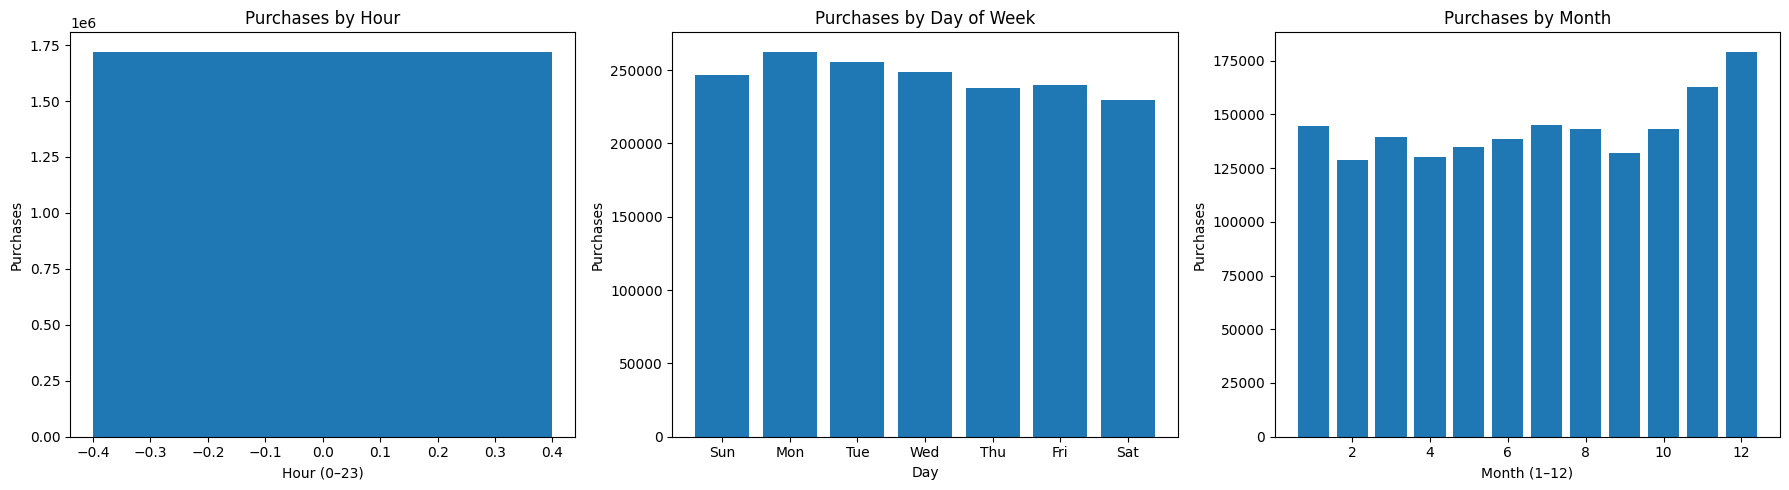

In [ ]:
# Convert to Pandas & plot
pdf_hour  = by_hour.toPandas()
pdf_day   = by_day.toPandas()
pdf_month = by_month.toPandas()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hour
axes[0].bar(pdf_hour["Hour"], pdf_hour["Purchases"])
axes[0].set_title("Purchases by Hour")
axes[0].set_xlabel("Hour (0–23)")
axes[0].set_ylabel("Purchases")

# Day (1=Sun … 7=Sat)
axes[1].bar(pdf_day["Day_Name"], pdf_day["Purchases"])
axes[1].set_title("Purchases by Day of Week")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Purchases")

# Month
axes[2].bar(pdf_month["Month"], pdf_month["Purchases"])
axes[2].set_title("Purchases by Month")
axes[2].set_xlabel("Month (1–12)")
axes[2].set_ylabel("Purchases")

plt.tight_layout()
plt.show()

In [ ]:
# Monthly Purchase Trends

from pyspark.sql.functions import date_format

# Extract month and year from 'Order Date'
df_time = df_final.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),  # works if already DateType/TimestampType
        to_timestamp(col("Order Date"), "MM/dd/yyyy HH:mm:ss"),
        to_timestamp(col("Order Date"), "MM/dd/yyyy HH:mm"),
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy HH:mm:ss"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy HH:mm"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)


In [ ]:
# Group by month and count purchases
df_monthly = (
    df_time
    .withColumn("YearMonth", date_format(col("Order_Timestamp"), "yyyy-MM"))
    .groupBy("YearMonth")
    .agg(count("*").alias("Purchases"))
    .orderBy("YearMonth")
)

# Convert to Pandas for visualisation
pdf = df_monthly.toPandas()

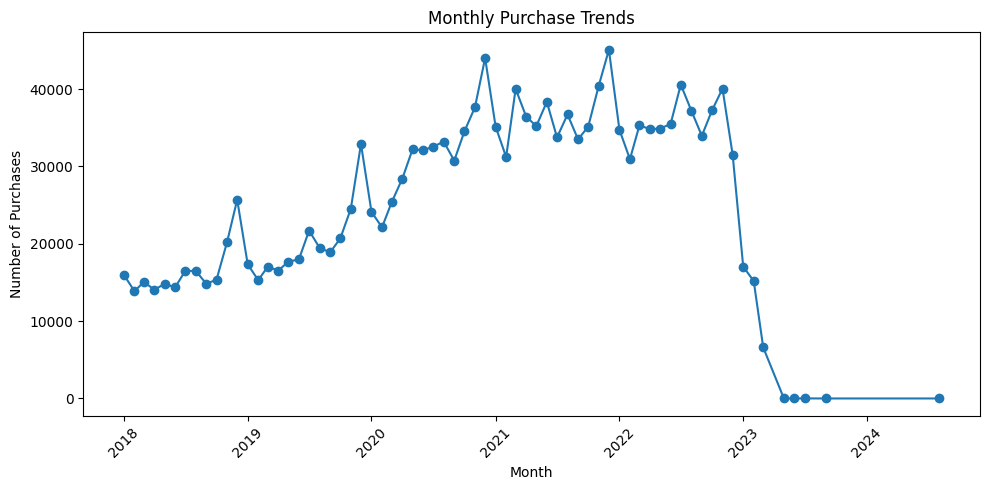

In [ ]:
import pandas as pd
# Ensure proper chronological order for plotting
pdf["YearMonth_dt"] = pd.to_datetime(pdf["YearMonth"], format="%Y-%m")
pdf = pdf.sort_values("YearMonth_dt")

# 4) Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf["YearMonth_dt"], pdf["Purchases"], marker="o")
plt.title("Monthly Purchase Trends")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Yealy Purchase Trends

from pyspark.sql.functions import col, count, year, to_timestamp, coalesce
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:

# Group by Year and count purchases
df_time = df_final.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),  # if already DateType/TimestampType
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)

In [ ]:
# Convert to Pandas for visualisation
df_yearly = (
    df_time
    .withColumn("Year", year(col("Order_Timestamp")))
    .groupBy("Year")
    .agg(count("*").alias("Purchases"))
    .orderBy("Year")
)


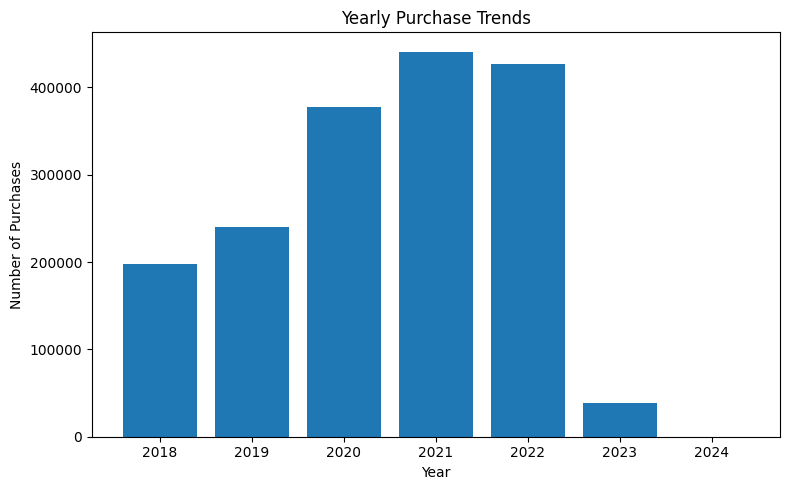

In [ ]:
# Convert to Pandas
pdf = df_yearly.toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(pdf["Year"], pdf["Purchases"])
plt.title("Yearly Purchase Trends")
plt.xlabel("Year")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.2 Customer Demographics vs Purchase Frequency <font color = red>[5 marks]</font> <br>
Analyse the trends between the customer deographics and the purchase frequency

In [ ]:
# Correlation Between Demographics and Purchase Frequency
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Group by demographic attributes and count purchases

#  Group by Gender
gender_df = (
    df_final.groupBy("Q-demos-gender")
    .agg(count("*").alias("Purchases"))
    .orderBy("Purchases", ascending=False)
)

# Group by Age
age_df = (
    df_final.groupBy("Q-demos-age")
    .agg(count("*").alias("Purchases"))
    .orderBy("Q-demos-age")
)

# Group by Income
income_df = (
    df_final.groupBy("Q-demos-income")
    .agg(count("*").alias("Purchases"))
    .orderBy("Purchases", ascending=False)
)


In [ ]:
# 4) Convert to Pandas
pdf_gender = gender_df.toPandas()
pdf_age    = age_df.toPandas()
pdf_income = income_df.toPandas()


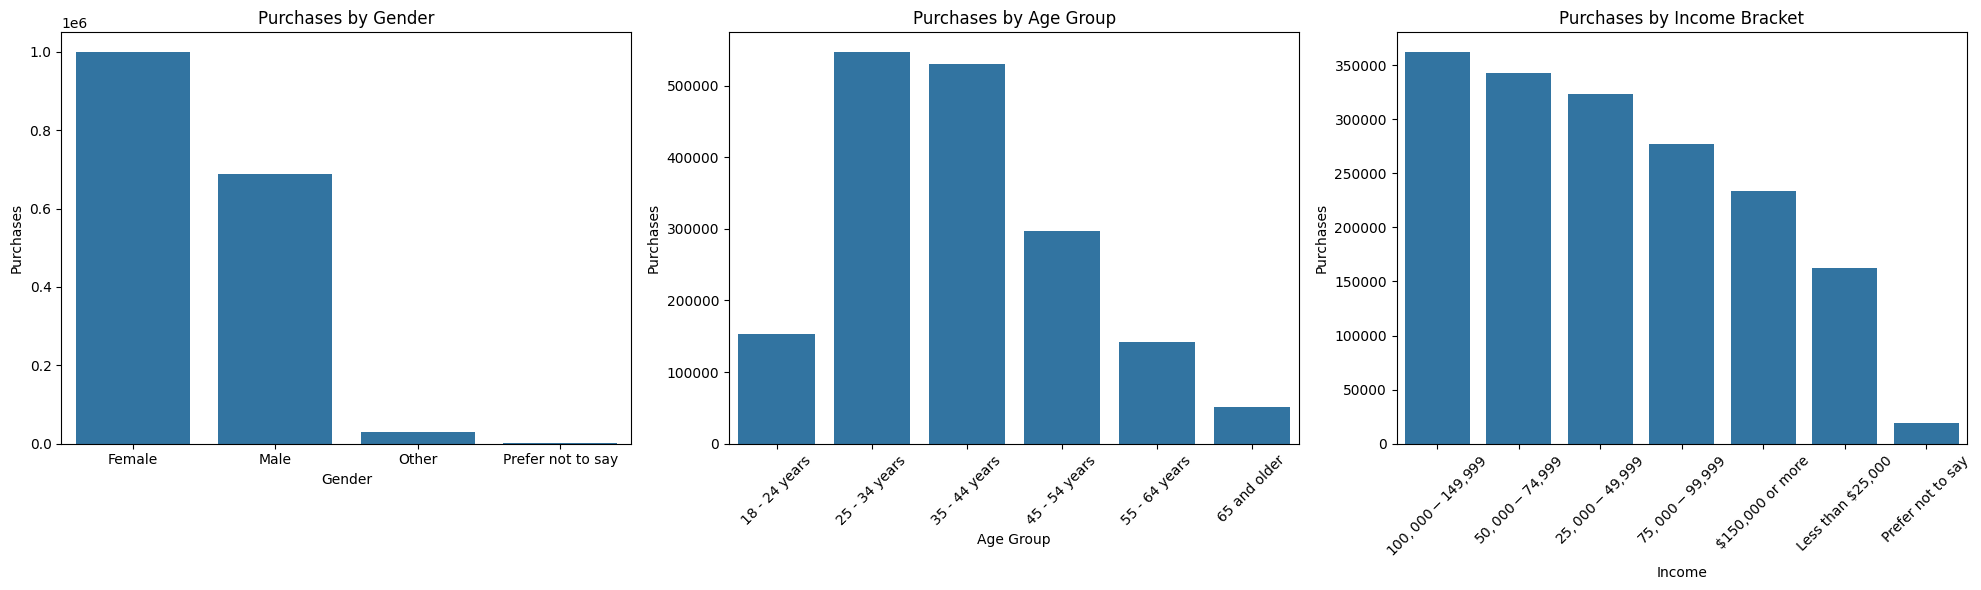

In [ ]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# Gender
sns.barplot(x="Q-demos-gender", y="Purchases", data=pdf_gender, ax=axes[0])
axes[0].set_title("Purchases by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Purchases")

# Age
sns.barplot(x="Q-demos-age", y="Purchases", data=pdf_age, ax=axes[1])
axes[1].set_title("Purchases by Age Group")
axes[1].set_xlabel("Age Group")
axes[1].set_ylabel("Purchases")
axes[1].tick_params(axis='x', rotation=45)

# Income
sns.barplot(x="Q-demos-income", y="Purchases", data=pdf_income, ax=axes[2])
axes[2].set_title("Purchases by Income Bracket")
axes[2].set_xlabel("Income")
axes[2].set_ylabel("Purchases")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3.3 Purchase behavior weekend vs weekday <font color = red>[5 marks]</font> <br>

Compare the purchase behavior of customer's on weekdays vs. weekends.

In [ ]:
# Weekday vs. Weekend Purchase Behavior

from pyspark.sql.functions import (
    col, when, dayofweek, count, to_timestamp, coalesce
)

In [ ]:
# Define weekdays and weekends
df_time = df_final.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),               # if already date/timestamp
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)


In [ ]:
# Group and count purchases
df_flag = df_time.withColumn("DayOfWeek", dayofweek(col("Order_Timestamp"))) \
                 .withColumn("DayType", when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday"))

# 3) Group and count purchases
by_daytype = df_flag.groupBy("DayType").agg(count("*").alias("Purchases"))

# Also compute percentages for context
total_purchases = by_daytype.agg(count("*")).collect()[0][0]  # number of categories (2), not sum
total_rows = df_flag.count()
from pyspark.sql.functions import lit
by_daytype = by_daytype.withColumn("Percent", (col("Purchases") / lit(total_rows)) * 100)

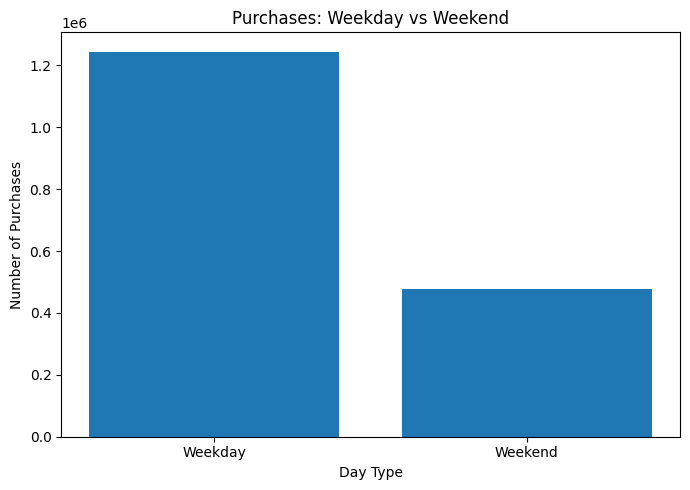

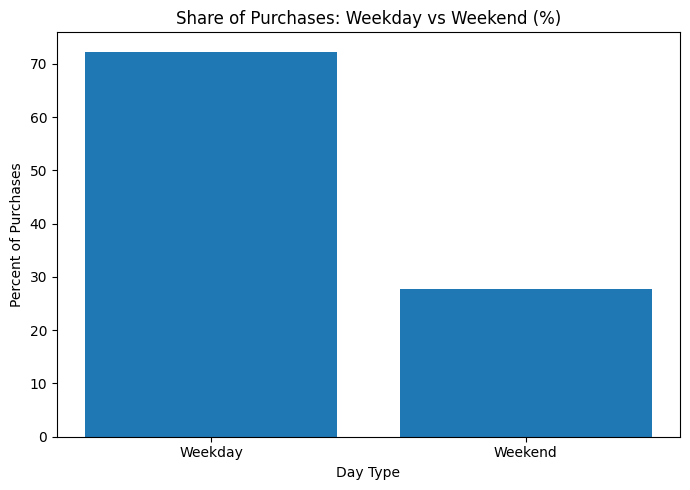

   DayType  Purchases    Percent
0  Weekday    1244366  72.309234
1  Weekend     476529  27.690766


In [ ]:
pdf = by_daytype.orderBy("DayType").toPandas()

# Plot (counts)
plt.figure(figsize=(7, 5))
plt.bar(pdf["DayType"], pdf["Purchases"])
plt.title("Purchases: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Number of Purchases")
plt.tight_layout()
plt.show()

# Plot (percentages)
plt.figure(figsize=(7, 5))
plt.bar(pdf["DayType"], pdf["Percent"])
plt.title("Share of Purchases: Weekday vs Weekend (%)")
plt.xlabel("Day Type")
plt.ylabel("Percent of Purchases")
plt.tight_layout()
plt.show()

# (Optional) print the table for reporting
print(pdf)

## 3.4 Frequently purchased product pairs <font color = red>[5 marks]</font> <br>

Analyze how frequently products are purchased together (also known as Market Basket Analysis)


In [ ]:
# Frequently Purchased Product Pairs (Market Basket Analysis)
from pyspark.sql.functions import col, collect_set, explode, size, to_timestamp, coalesce
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import udf
from itertools import combinations
import matplotlib.pyplot as plt

In [ ]:
# Build basket key (Survey ResponseID + Order Date)
df_baskets = df_final.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)

# Collect products per basket
baskets = (
    df_baskets
    .filter(col("Title").isNotNull())
    .groupBy("Survey ResponseID", "Order_Timestamp")
    .agg(collect_set(col("Title")).alias("items"))
    .filter(size(col("items")) >= 2)   # keep only baskets with 2+ items
)

+----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+-----+
|Item_A                                                                                                    |Item_B                                                                                                   |count|
+----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+-----+
|Amazon Basics 36 Pack AAA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack|Amazon Basics 48 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack|118  |
|Amazon Music Unlimited                                                                                    |Echo Dot

/tmp/ipython-input-2801055559.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


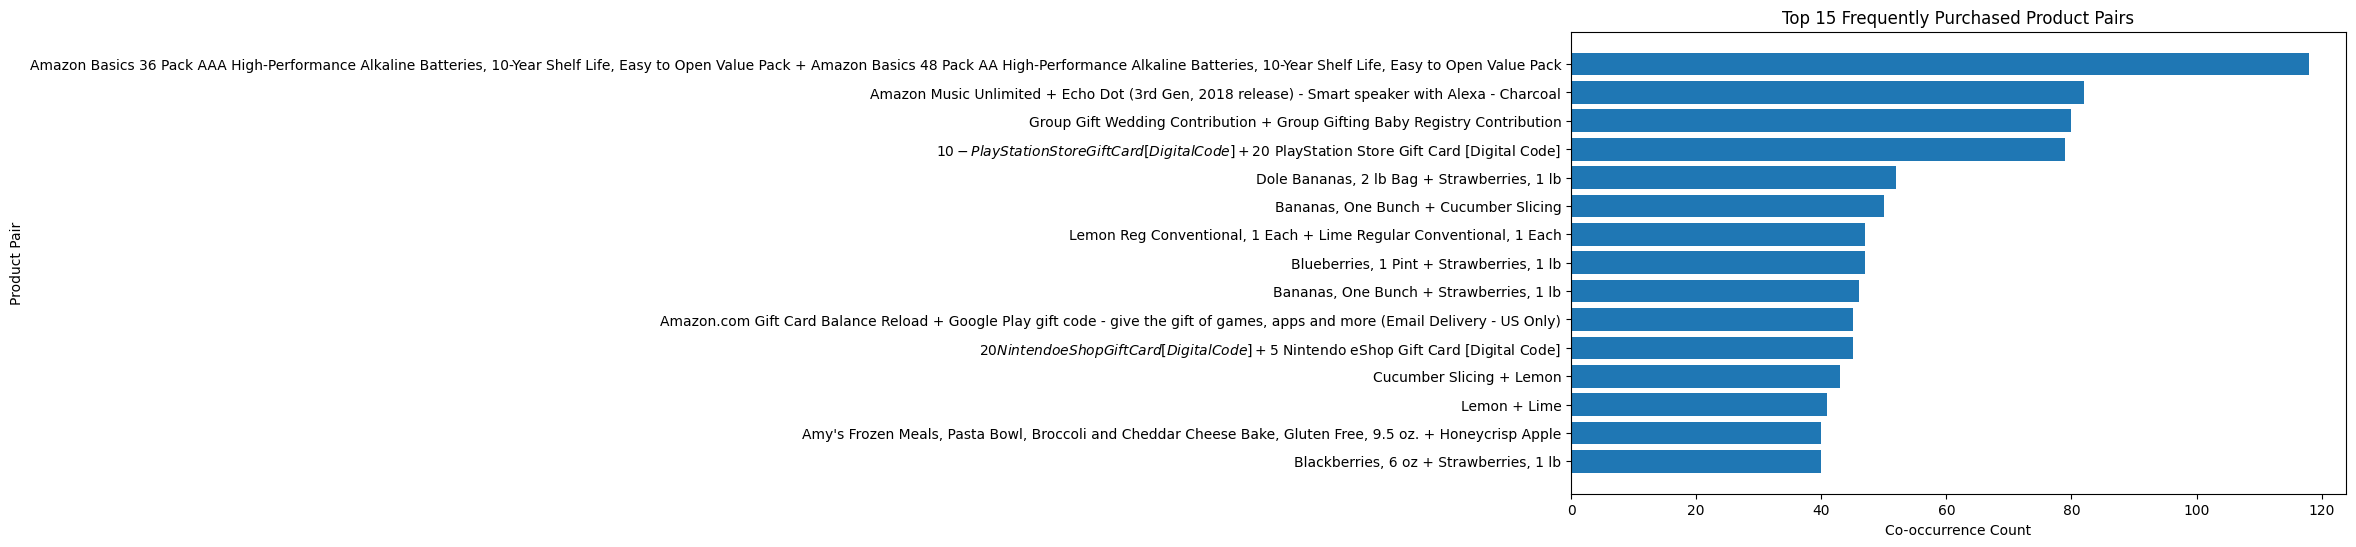

In [ ]:
#  UDF to generate pairs
pair_schema = ArrayType(
    StructType([StructField("item_a", StringType()), StructField("item_b", StringType())])
)

@udf(returnType=pair_schema)
def item_pairs(items):
    uniq = sorted(set(items))
    return [{"item_a": a, "item_b": b} for a, b in combinations(uniq, 2)]

pairs_df = baskets.select(explode(item_pairs(col("items"))).alias("pair")) \
                  .select(col("pair.item_a").alias("Item_A"),
                          col("pair.item_b").alias("Item_B"))

# Count co-occurrences
pair_counts = pairs_df.groupBy("Item_A", "Item_B").count().orderBy(col("count").desc())

# Show and plot Top N pairs
topN = 15
pair_counts.show(topN, truncate=False)

pdf_pairs = pair_counts.limit(topN).toPandas()

plt.figure(figsize=(10, 6))
labels = [f"{a} + {b}" for a, b in zip(pdf_pairs["Item_A"], pdf_pairs["Item_B"])]
plt.barh(labels[::-1], pdf_pairs["count"][::-1])
plt.title(f"Top {topN} Frequently Purchased Product Pairs")
plt.xlabel("Co-occurrence Count")
plt.ylabel("Product Pair")
plt.tight_layout()
plt.show()

## 3.5 Examine Product Performance <font color = red>[5 marks]</font> <br>

Examine the performance of products by calculating revenue and item popularity.

In [ ]:
# Contribution of Product Categories (Top 25)
product_perf = (
    df.groupBy("Title")
    .agg(
        spark_sum("Total_Value").alias("Total_Revenue"),
        spark_sum("Quantity").alias("Total_Quantity")
    )
    .orderBy(col("Total_Revenue").desc())
)

# 2) Take top 25 products by revenue
topN = 25
top_products = product_perf.limit(topN).toPandas()

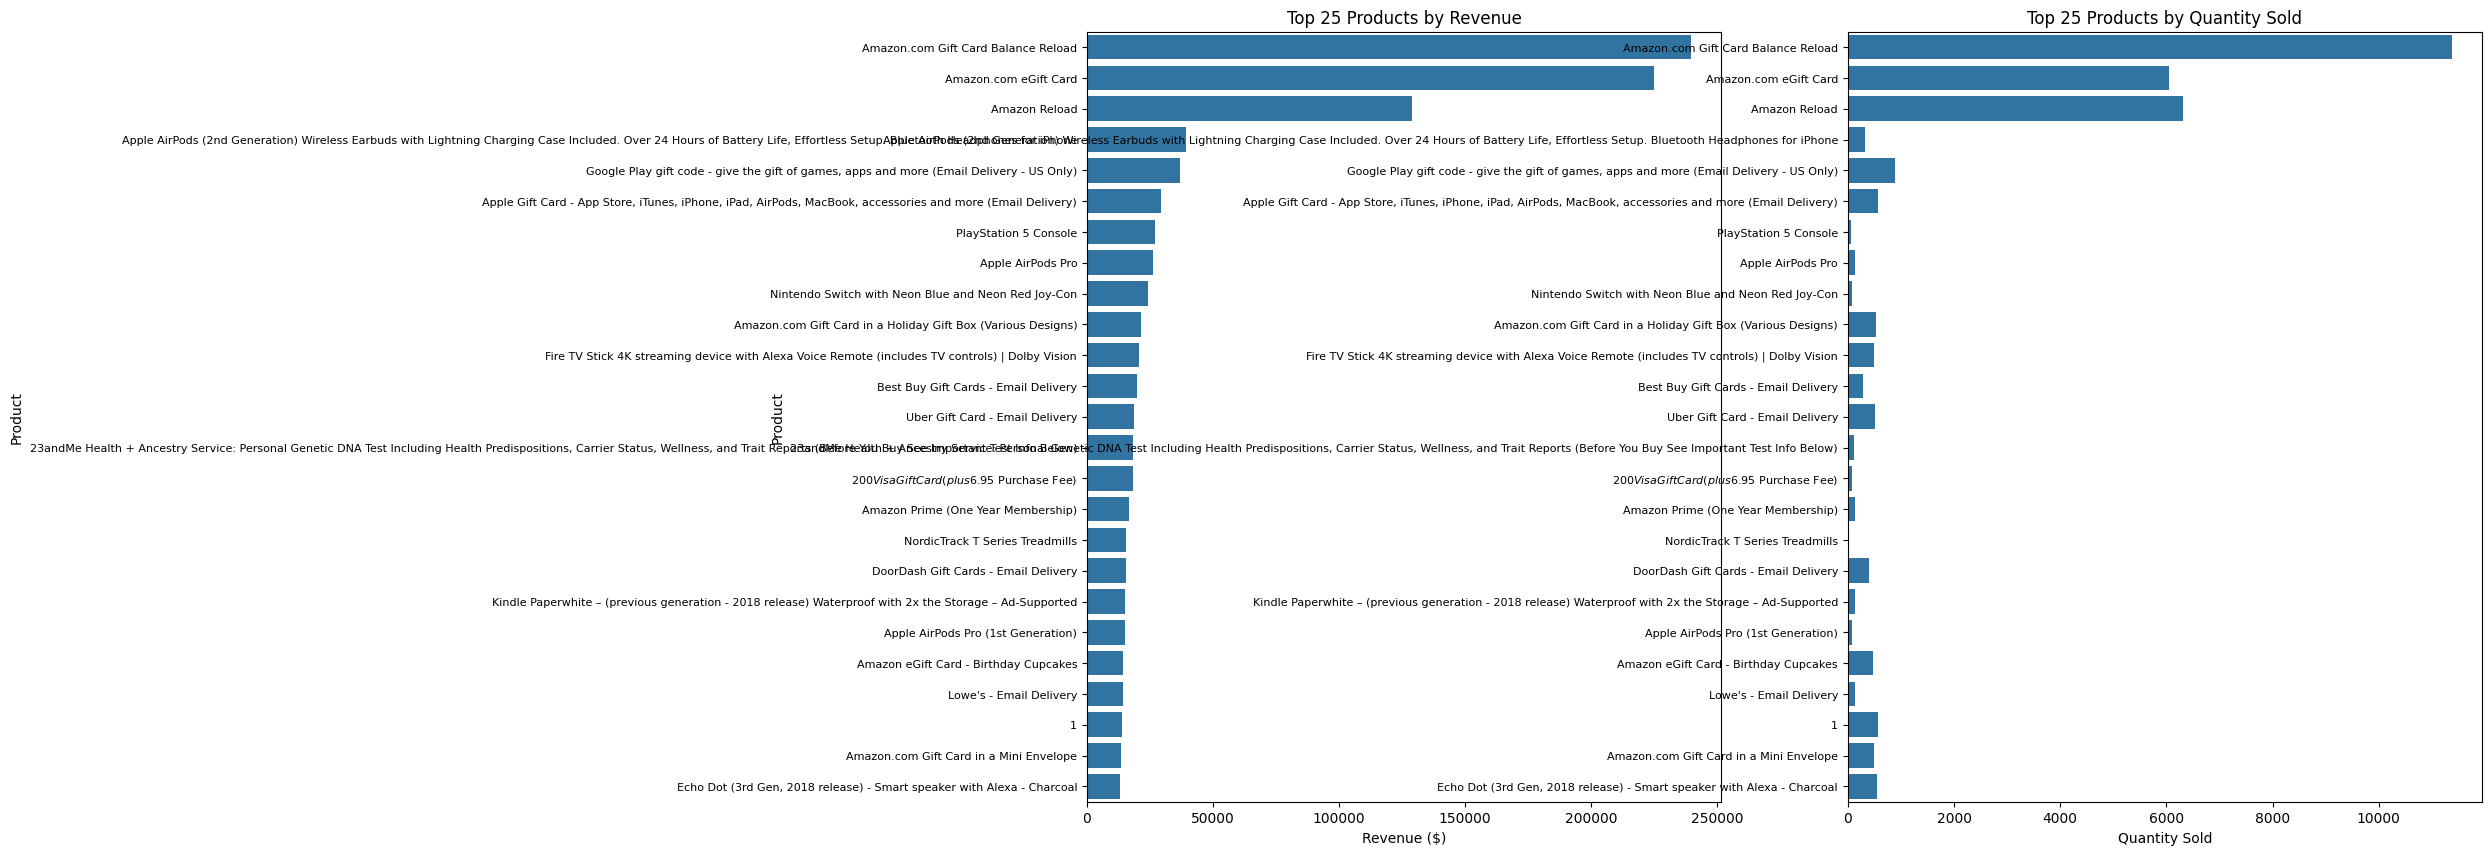

In [ ]:
# Plot: Revenue and Quantity
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Revenue
sns.barplot(x="Total_Revenue", y="Title", data=top_products, ax=axes[0])
axes[0].set_title(f"Top {topN} Products by Revenue")
axes[0].set_xlabel("Revenue ($)")
axes[0].set_ylabel("Product")
axes[0].tick_params(axis="y", labelsize=8)

# Popularity
sns.barplot(x="Total_Quantity", y="Title", data=top_products, ax=axes[1])
axes[1].set_title(f"Top {topN} Products by Quantity Sold")
axes[1].set_xlabel("Quantity Sold")
axes[1].set_ylabel("Product")
axes[1].tick_params(axis="y", labelsize=8)

## 3.6 Top products by quantity <font color = red>[5 marks]</font> <br>

Identify the most frequently purchased products.

In [ ]:
# Top 10 Products by Quantity

# Group by Title and sum Quantity
product_quantity = (
    df.groupBy("Title")
    .agg(spark_sum("Quantity").alias("Total_Quantity"))
    .orderBy(col("Total_Quantity").desc())
)

# Convert to Pandas for visualisation
topN = 10
top_products_qty = product_quantity.limit(topN).toPandas()


/tmp/ipython-input-2405963124.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Title", x="Total_Quantity", data=top_products_qty, palette="Blues_r")


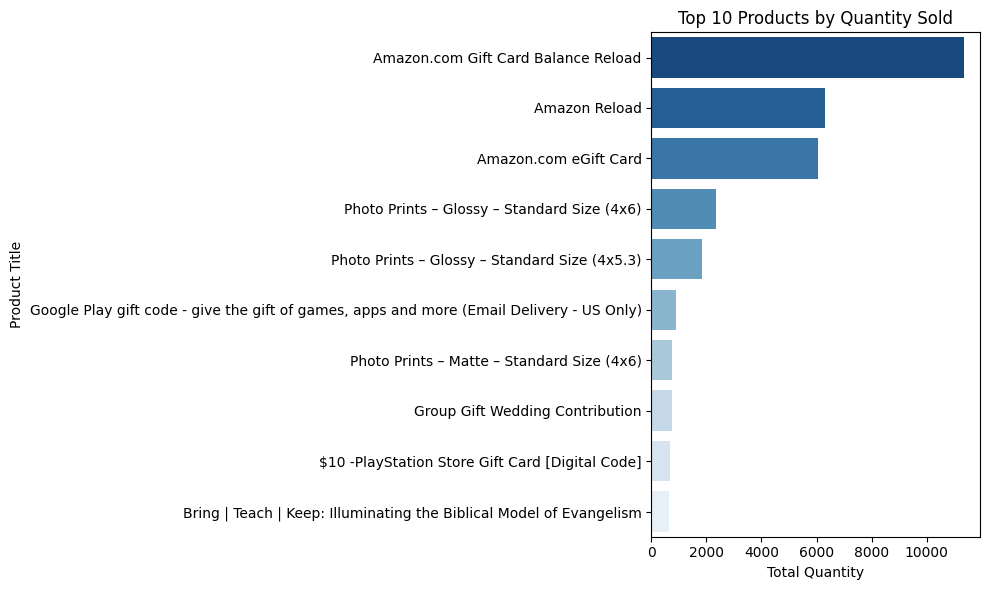

In [ ]:
# Plot horizontally for readability
plt.figure(figsize=(10, 6))
sns.barplot(y="Title", x="Total_Quantity", data=top_products_qty, palette="Blues_r")
plt.title(f"Top {topN} Products by Quantity Sold")
plt.xlabel("Total Quantity")
plt.ylabel("Product Title")
plt.tight_layout()
plt.show()

## 3.7 Distribution of Purchases by State <font color = red>[5 marks]</font> <br>

Analyze the distribution of purchases across states and categories.

/tmp/ipython-input-982068628.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Shipping Address State", x="Total_Purchases", data=top_states, palette="viridis")


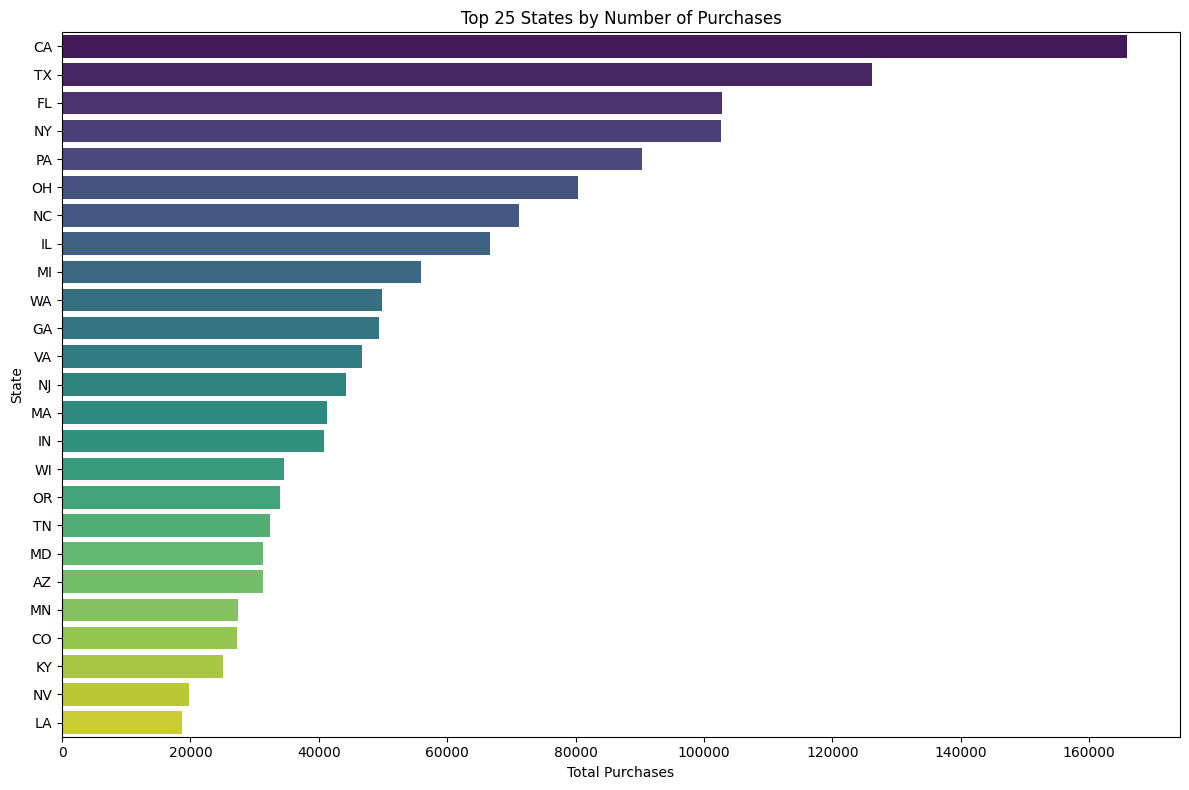

In [ ]:
# Distribution of Purchases by State (Top 25)
state_category = (
    df.groupBy("Shipping Address State", "Category")
    .agg(
        spark_sum("Quantity").alias("Total_Quantity"),
        spark_sum("Total_Value").alias("Total_Revenue"),
        count("*").alias("Purchase_Count")
    )
)

#  Total purchases per state (all categories)
state_summary = (
    state_category.groupBy("Shipping Address State")
    .agg(
        spark_sum("Total_Quantity").alias("Total_Quantity"),
        spark_sum("Total_Revenue").alias("Total_Revenue"),
        spark_sum("Purchase_Count").alias("Total_Purchases")
    )
    .orderBy(col("Total_Purchases").desc())
)

# Convert to Pandas for visualisation
topN = 25
top_states = state_summary.limit(topN).toPandas()

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(y="Shipping Address State", x="Total_Purchases", data=top_states, palette="viridis")
plt.title(f"Top {topN} States by Number of Purchases")
plt.xlabel("Total Purchases")
plt.ylabel("State")
plt.tight_layout()
plt.show()

## 3.8 Price vs Product Quantity <font color = red>[5 marks]</font> <br>

Identify the Relationship between Price and Quantity

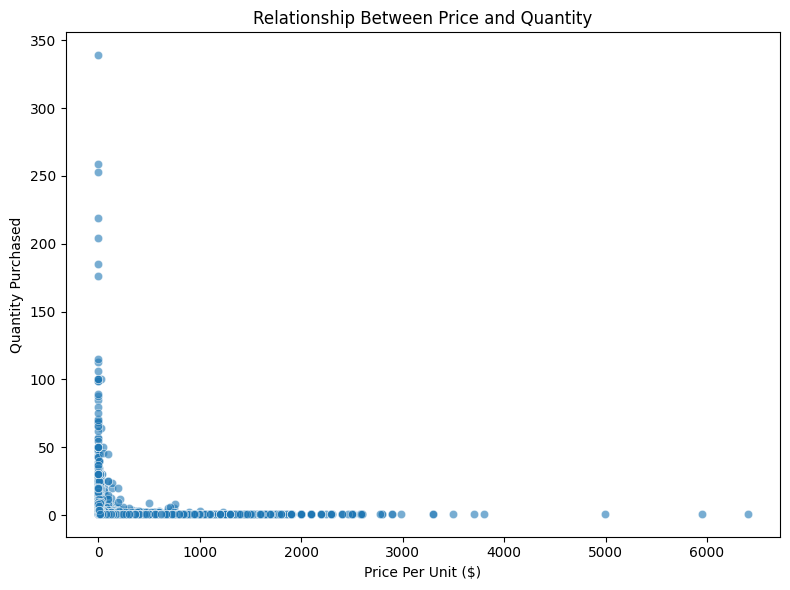

In [ ]:
# Relationship Between Price and Quantity
price_qty = df.select("Purchase Price Per Unit", "Quantity")

# Convert to Pandas for visualisation
pdf_price_qty = price_qty.toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Purchase Price Per Unit", y="Quantity", data=pdf_price_qty, alpha=0.6)

plt.title("Relationship Between Price and Quantity")
plt.xlabel("Price Per Unit ($)")
plt.ylabel("Quantity Purchased")
plt.tight_layout()
plt.show()

## 3.9 Analyse the spending KPIs <font color = red>[5 marks]</font> <br>


A popular KPI is average spend per customer. Calculate this metric as the ratio of total transaction amount from non-recurring payments divided by the total number of customers who made a purchase

Average Spend per Customer: $8002.03


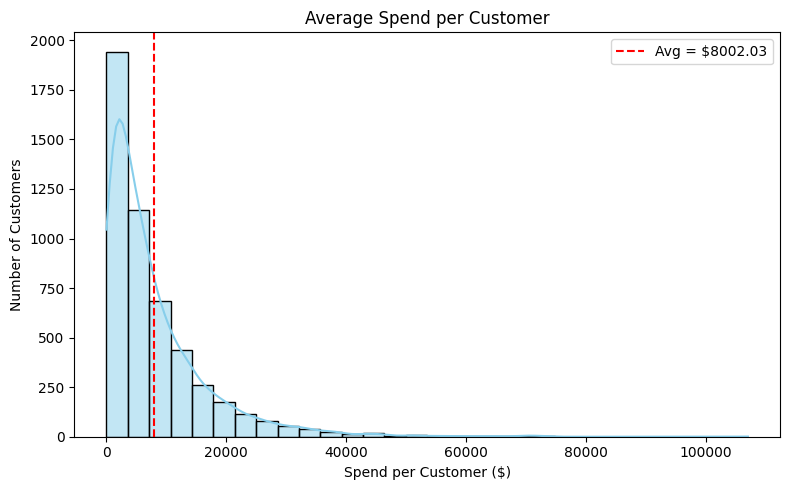

In [ ]:
# Average Spend per Customer

from pyspark.sql.functions import avg

# Group by customer and calculate average spend
customer_spend = (
    df.groupBy("Survey ResponseID")
      .agg(spark_sum("Total_Value").alias("Customer_Spend"))
)

# Compute the overall average
avg_spend = customer_spend.agg({"Customer_Spend": "avg"}).collect()[0][0]
print(f"Average Spend per Customer: ${avg_spend:.2f}")

# Convert to Pandas for visualisation (optional)
pdf_customer_spend = customer_spend.toPandas()

# Plot (distribution of customer spends)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(pdf_customer_spend["Customer_Spend"], bins=30, kde=True, color="skyblue")
plt.axvline(avg_spend, color="red", linestyle="--", label=f"Avg = ${avg_spend:.2f}")
plt.title("Average Spend per Customer")
plt.xlabel("Spend per Customer ($)")
plt.ylabel("Number of Customers")
plt.legend()
plt.tight_layout()
plt.show()

Analyse the Repeat Purchase Behavior of Customers

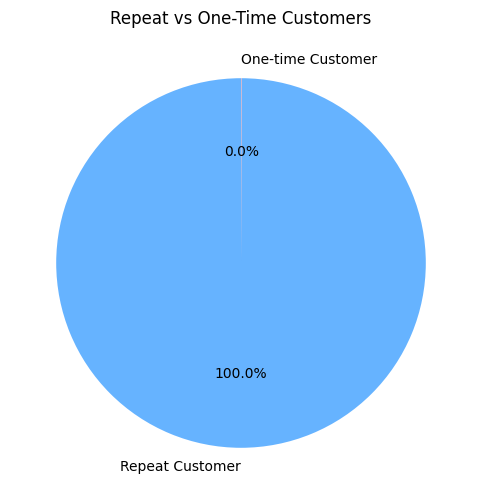

       Purchase_Type  Num_Customers
0    Repeat Customer           5019
1  One-time Customer              2


In [ ]:
# Repeat Purchase Analysis Behavior Per Customers

# Count purchases per customer
customer_purchases = (
    df.groupBy("Survey ResponseID")
      .agg(count("*").alias("Purchase_Count"))
)

# Split customers into repeat vs one-time
repeat_summary = (
    customer_purchases
    .withColumn("Purchase_Type",
                when(col("Purchase_Count") > 1, "Repeat Customer")
                .otherwise("One-time Customer"))
    .groupBy("Purchase_Type")
    .agg(count("*").alias("Num_Customers"))
)

#  Convert to Pandas
pdf_repeat = repeat_summary.toPandas()

# Plot
plt.figure(figsize=(6, 6))
plt.pie(pdf_repeat["Num_Customers"], labels=pdf_repeat["Purchase_Type"], autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff9999"])
plt.title("Repeat vs One-Time Customers")
plt.show()

print(pdf_repeat)

Analyse the top 10 high-engagement customers

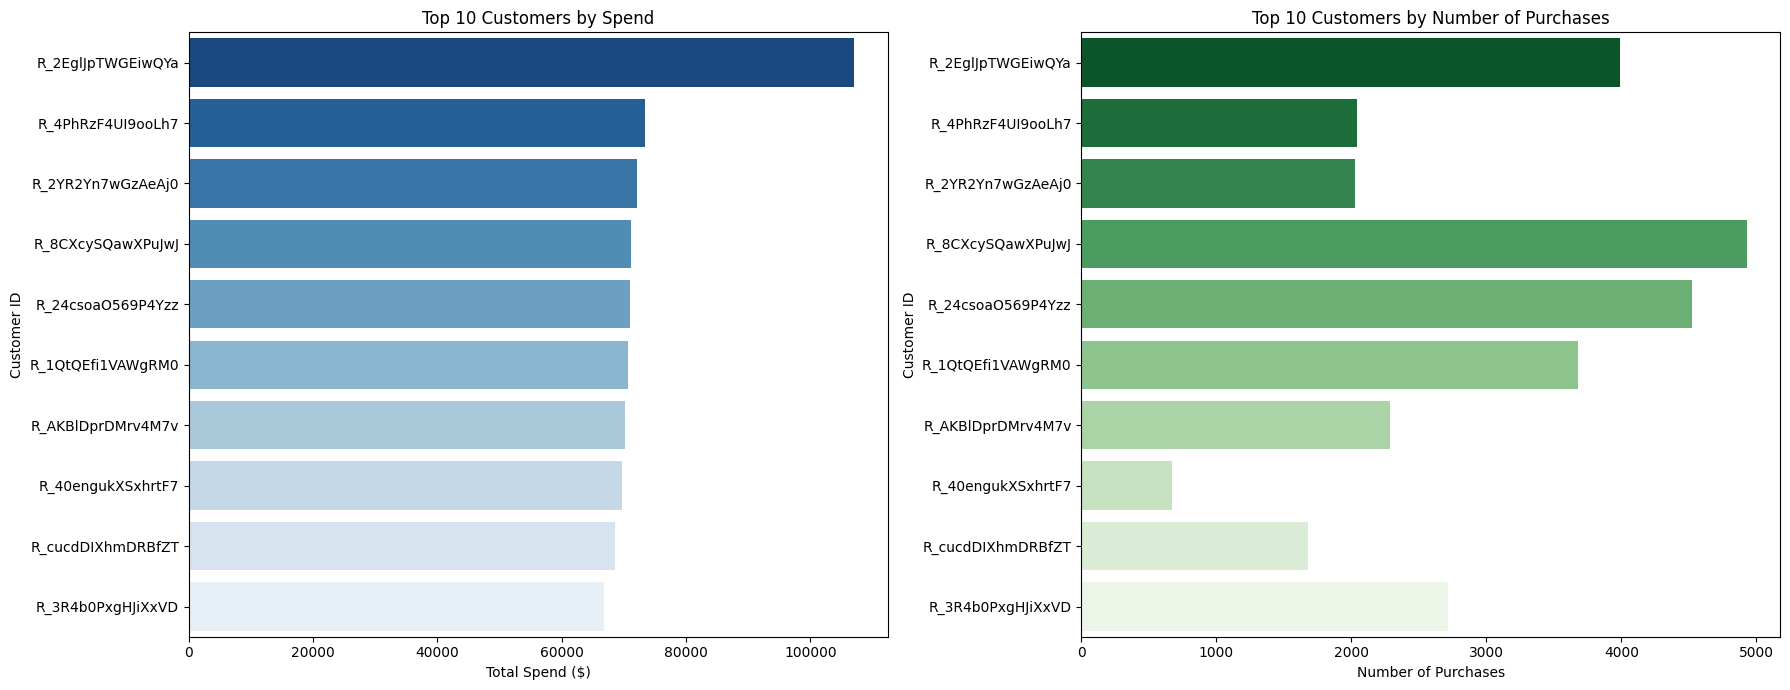

In [ ]:
# Top 10 High-Engagement Customers
customer_engagement = (
    df.groupBy("Survey ResponseID")
      .agg(
          spark_sum("Total_Value").alias("Total_Spend"),
          count("*").alias("Num_Purchases")
      )
      .orderBy(col("Total_Spend").desc())  # rank by spend
)

# Convert to Pandas for visualisation
topN = 10
top_customers = customer_engagement.limit(topN).toPandas()

# Plot

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Revenue
sns.barplot(y="Survey ResponseID", x="Total_Spend",
            hue="Survey ResponseID", data=top_customers, ax=axes[0],
            palette="Blues_r", legend=False)
axes[0].set_title(f"Top {topN} Customers by Spend")
axes[0].set_xlabel("Total Spend ($)")
axes[0].set_ylabel("Customer ID")

# Purchases
sns.barplot(y="Survey ResponseID", x="Num_Purchases",
            hue="Survey ResponseID", data=top_customers, ax=axes[1],
            palette="Greens_r", legend=False)
axes[1].set_title(f"Top {topN} Customers by Number of Purchases")
axes[1].set_xlabel("Number of Purchases")
axes[1].set_ylabel("Customer ID")

plt.tight_layout()
plt.show()

## 3.10 Seasonal trends in product purchases and their impact on revenues <font color = red>[5 marks]</font> <br>

Investigate the seasonal trends in product purchases and their impact on the overall revenue.

In [ ]:
# Seasonal Trends in Product Purchases and Their Impact on Revenue

from pyspark.sql.functions import (
    col, year, month, to_timestamp, coalesce, sum as spark_sum
)

base_df = df if 'df' in globals() else df_final

df_time = base_df.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),                 # if already Date/Timestamp
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)
# If Total_Value is missing, create it (Price × Quantity)
if "Total_Value" not in df_time.columns:
    df_time = df_time.withColumn("Purchase Price Per Unit", col("Purchase Price Per Unit").cast("double")) \
                     .withColumn("Quantity", col("Quantity").cast("int")) \
                     .withColumn("Total_Value", col("Purchase Price Per Unit") * col("Quantity"))


+----+-----+------------------+
|Year|Month|Total_Revenue     |
+----+-----+------------------+
|2018|1    |366746.0700000018 |
|2018|2    |324627.5400000062 |
|2018|3    |343352.6600000047 |
|2018|4    |317467.35000000685|
|2018|5    |355826.93000000424|
|2018|6    |345934.17000000377|
|2018|7    |441440.1299999978 |
|2018|8    |392353.570000001  |
|2018|9    |355715.57000000426|
|2018|10   |362352.3000000035 |
|2018|11   |515042.27999999374|
|2018|12   |614985.5099999848 |
|2019|1    |398599.56000000145|
|2019|2    |382045.5700000016 |
|2019|3    |394338.6399999999 |
|2019|4    |394129.5300000008 |
|2019|5    |421244.5399999993 |
|2019|6    |432464.7999999971 |
|2019|7    |555772.9799999886 |
|2019|8    |439615.74999999744|
+----+-----+------------------+
only showing top 20 rows



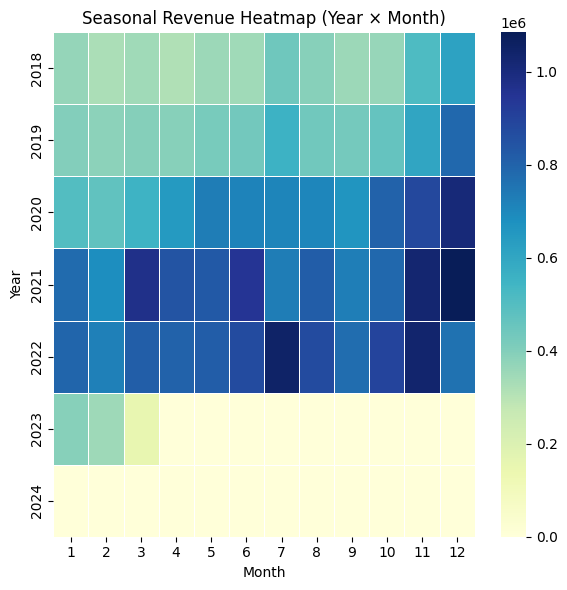

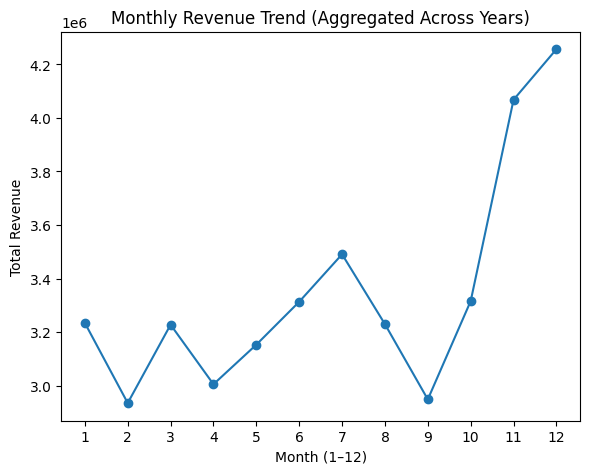

In [ ]:
# Extract year and month
df_season = df_time.withColumn("Year",  year(col("Order_Timestamp"))) \
                   .withColumn("Month", month(col("Order_Timestamp")))

# Group by year and month, summing total revenue
monthly_revenue = (df_season
                   .groupBy("Year", "Month")
                   .agg(spark_sum("Total_Value").alias("Total_Revenue"))
                   .orderBy("Year", "Month")
                  )

monthly_revenue.show(20, truncate=False)

# Convert to Pandas for visualisation
pdf = monthly_revenue.toPandas().dropna(subset=["Year", "Month"])
pdf["Year"]  = pdf["Year"].astype(int)
pdf["Month"] = pdf["Month"].astype(int)


# Plot
#  Heatmap: Revenue by Year × Month
pivot_rev = pdf.pivot(index="Year", columns="Month", values="Total_Revenue").fillna(0)

plt.figure(figsize=(6, 6))
sns.heatmap(pivot_rev, cmap="YlGnBu", linewidths=.5)
plt.title("Seasonal Revenue Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

# Overall Monthly Trend (aggregated across years)
monthly_totals = (pdf.groupby("Month", as_index=False)["Total_Revenue"].sum()
                    .sort_values("Month"))

plt.figure(figsize=(6, 5))
plt.plot(monthly_totals["Month"], monthly_totals["Total_Revenue"], marker="o")
plt.title("Monthly Revenue Trend (Aggregated Across Years)")
plt.xlabel("Month (1–12)")
plt.ylabel("Total Revenue")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

## 3.11 Customer location vs purchasing behavior <font color = red>[5 marks]</font> <br>

Examine the relationship between customer's location and their purchasing behaviors

/tmp/ipython-input-1305577278.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


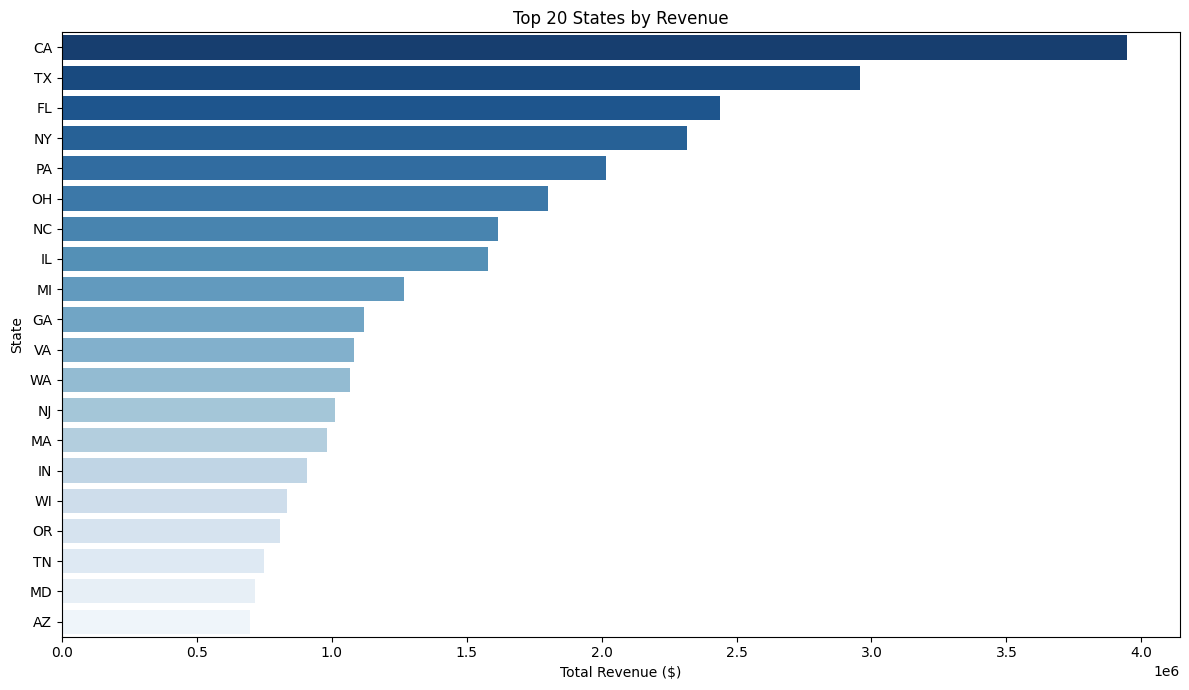

In [ ]:
# Relationship Between Customer Location and Purchase Behavior

# Group purchases by state and total spend
state_summary = (
    df.groupBy("Shipping Address State")
      .agg(
          count("*").alias("Total_Purchases"),
          spark_sum("Quantity").alias("Total_Quantity"),
          spark_sum("Total_Value").alias("Total_Revenue")
      )
      .orderBy(col("Total_Revenue").desc())
)

# Convert to Pandas for visualisation
pdf_states = state_summary.toPandas()

# Plot revenue by state
topN = 20
plt.figure(figsize=(12, 7))
sns.barplot(
    y="Shipping Address State", x="Total_Revenue",
    data=pdf_states.head(topN), palette="Blues_r"
)
plt.title(f"Top {topN} States by Revenue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


#4. Customer Segmentation and Insights <font color = red>[45 marks]</font> <br>


## 4.1 Perform RFM Analysis <font color = red>[10 marks]</font> <br>

RFM Analysis is a powerful customer segmentation technique used to evaluate and quantify customer value based on three key dimensions:
- **Recency**,
- **Frequency**,
- **Monetary**.

This method is particularly effective in identifying high-value customers, optimizing marketing strategies, and improving customer retention in the e-commerce industry.


### 1. Recency (R)
Recency measures how recently a customer made a purchase Customers who have purchased more recently are more likely to respond to promotions and offers.
- **Application:** By ranking customers based on the number of days since their last transaction, you can prioritize those who are most engaged.

### 2. Frequency (F)
Frequency counts the number of purchases a customer has made over a given period.
Frequent purchasers tend to be more loyal and are often a source of recurring revenue.
- **Application:** Analyzing purchase frequency helps in identifying consistent buyers and understanding their buying patterns.

### 3. Monetary (M)
Monetary value represents the total amount of money a customer has spent.
Customers who spend more are often more profitable, making them ideal targets for retention and upsell strategies.
- **Application:** By assessing the monetary contribution, you can distinguish between high-value and low-value customers.


### Prepare data for RFM Analysis <font color = red>[2 marks]</font> <br>


In [ ]:
from pyspark.sql.functions import (
    col, to_timestamp, coalesce, datediff, lit,
    max as spark_max, count as spark_count, sum as spark_sum
)

# 0) Pick the working DF (engineered df if present, else cleaned)
base_df = df if 'df' in globals() else df_final

# 1) Ensure a proper timestamp column exists
df_rfm = base_df.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),                  # works if already Date/Timestamp
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)
# If you previously created Order_Date (DateType), use it as fallback:
if "Order_Timestamp" not in df_rfm.columns or df_rfm.select(col("Order_Timestamp").isNull().cast("int")).agg({"*":"sum"}).collect()[0][0] > 0:
    if "Order_Date" in df_rfm.columns:
        df_rfm = df_rfm.withColumn("Order_Timestamp", to_timestamp(col("Order_Date")))

# 2) Ensure monetary column exists: Total_Value = Unit Price × Quantity
if "Total_Value" not in df_rfm.columns:
    df_rfm = (df_rfm
              .withColumn("Purchase Price Per Unit", col("Purchase Price Per Unit").cast("double"))
              .withColumn("Quantity", col("Quantity").cast("int"))
              .withColumn("Total_Value", col("Purchase Price Per Unit") * col("Quantity"))
             )

# 3) Get latest order date in dataset
max_order_date = df_rfm.agg(spark_max("Order_Timestamp").alias("MaxDate")).collect()[0]["MaxDate"]
print("Latest Order Date in dataset:", max_order_date)

# 4) Compute RFM per customer (Survey ResponseID)
rfm = (df_rfm.groupBy("Survey ResponseID")
       .agg(
           spark_max("Order_Timestamp").alias("Last_Purchase_Date"),
           spark_count("*").alias("Frequency"),
           spark_sum("Total_Value").alias("Monetary")
       ))

# 5) Recency = days since last purchase
rfm = rfm.withColumn("Recency", datediff(lit(max_order_date), col("Last_Purchase_Date")))

# 6) Keep only customers with at least 1 purchase (Frequency > 0)
rfm = rfm.filter(col("Frequency") > 0)

# 7) Show RFM data
rfm.select("Survey ResponseID", "Recency", "Frequency", "Monetary").show(10, truncate=False)


Latest Order Date in dataset: 2024-08-15 00:00:00
+-----------------+-------+---------+------------------+
|Survey ResponseID|Recency|Frequency|Monetary          |
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|525    |1058     |28274.68000000031 |
|R_1CqGMkfiCiATbn4|528    |182      |5775.45999999999  |
|R_1LBvKYfg8hgoloJ|1896   |7        |326.78            |
|R_1N52McSjcCnVqIm|590    |11       |267.71999999999997|
|R_1NfYBCMTmzHgXGh|640    |3        |47.919999999999995|
|R_1QgWXnlpERvWjrY|645    |78       |1203.7200000000003|
|R_1eWdieBjoYJXAYv|606    |920      |26188.560000000245|
|R_1esG9Jlh9NISLaO|529    |357      |6621.719999999969 |
|R_1gG5xibh48txT6f|523    |590      |12959.079999999933|
|R_1jO4s7oht3pyKEc|518    |596      |12619.349999999935|
+-----------------+-------+---------+------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import log1p

# Apply log transformation to skewed features
rfm_log = (
    rfm.withColumn("Recency_log", log1p("Recency"))
       .withColumn("Frequency_log", log1p("Frequency"))
       .withColumn("Monetary_log", log1p("Monetary"))
)

In [ ]:
# Convert to Pandas DataFrame (for scikit-learn compatibility)
pdf_rfm = rfm_log.select("Recency_log", "Frequency_log", "Monetary_log").toPandas()


In [ ]:
# Scale features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(pdf_rfm)

# Convert back into a DataFrame for easier handling
import pandas as pd
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]
)

rfm_scaled_df.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
0,-0.747573,1.399935,1.477749
1,-0.718425,-0.006457,0.230197
2,5.826596,-2.513909,-2.023584
3,-0.150418,-2.189094,-2.179643
4,0.265813,-3.069183,-3.517742


In [ ]:
from sklearn.cluster import KMeans

# Calculate the Within-Cluster Sum of Squares (WCSS)
if 'rfm_scaled' in globals():
    X = rfm_scaled
elif 'rfm_scaled_df' in globals():
    X = rfm_scaled_df.values
else:
    raise NameError("Scaled features not found. Define `rfm_scaled` or `rfm_scaled_df` first.")


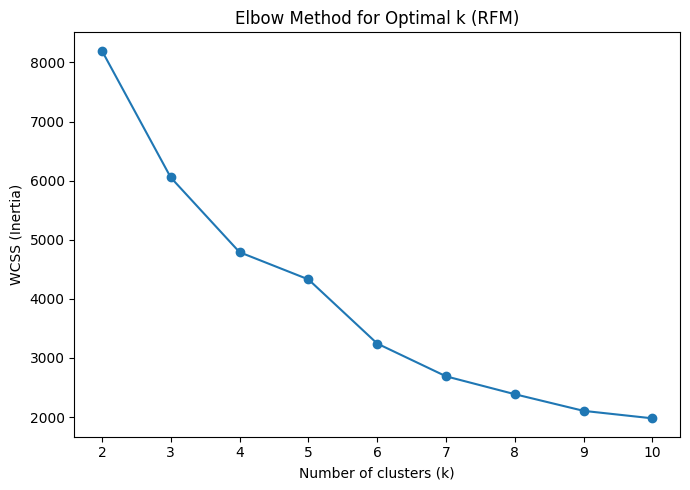

In [ ]:
# Plot the elbow curve with the number of clusters on the x-axis and WCSS on the y-axis
k_values = list(range(2, 11))
wcss = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X)
    wcss.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(7,5))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for Optimal k (RFM)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(k_values)
plt.tight_layout()
plt.show()

In [ ]:
# Fit the K-Means model using the optimal number of clusters obtained after understanding the elblow plot

# Scale features (fit on all rows)
from sklearn.preprocessing import StandardScaler
from pyspark.sql.functions import log1p

# Make sure we have log-transformed features in Spark
rfm_log = (
    rfm.withColumn("Recency_log", log1p("Recency"))
       .withColumn("Frequency_log", log1p("Frequency"))
       .withColumn("Monetary_log", log1p("Monetary"))
)

# Convert Spark → Pandas
pdf_feats = rfm_log.select(
    "Survey ResponseID", "Recency_log", "Frequency_log", "Monetary_log"
).toPandas()

# Scale features
X = pdf_feats[["Recency_log", "Frequency_log", "Monetary_log"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Fit K-Means with chosen k (from elbow plot)
optimal_k = 4   # <-- adjust this based on your elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled)

# 5) Add cluster labels back to Pandas DataFrame
pdf_feats["RFM_Cluster"] = labels

#  Convert back to Spark and join with original RFM
rfm_clusters_spark = spark.createDataFrame(
    pdf_feats[["Survey ResponseID", "RFM_Cluster"]]
)

rfm_with_cluster = rfm.join(rfm_clusters_spark, on="Survey ResponseID", how="left")

#  Show sample results
rfm_with_cluster.select(
    "Survey ResponseID", "Recency", "Frequency", "Monetary", "RFM_Cluster"
).show(10, truncate=False)

+-----------------+-------+---------+------------------+-----------+
|Survey ResponseID|Recency|Frequency|Monetary          |RFM_Cluster|
+-----------------+-------+---------+------------------+-----------+
|R_10TV1zyi4yCEEkl|525    |1058     |28274.68000000031 |1          |
|R_1CqGMkfiCiATbn4|528    |182      |5775.45999999999  |2          |
|R_1LBvKYfg8hgoloJ|1896   |7        |326.78            |0          |
|R_1N52McSjcCnVqIm|590    |11       |267.71999999999997|3          |
|R_1NfYBCMTmzHgXGh|640    |3        |47.919999999999995|3          |
|R_1QgWXnlpERvWjrY|645    |78       |1203.7200000000003|3          |
|R_1eWdieBjoYJXAYv|606    |920      |26188.560000000245|1          |
|R_1esG9Jlh9NISLaO|529    |357      |6621.719999999969 |1          |
|R_1gG5xibh48txT6f|523    |590      |12959.079999999933|1          |
|R_1jO4s7oht3pyKEc|518    |596      |12619.349999999935|1          |
+-----------------+-------+---------+------------------+-----------+
only showing top 10 rows



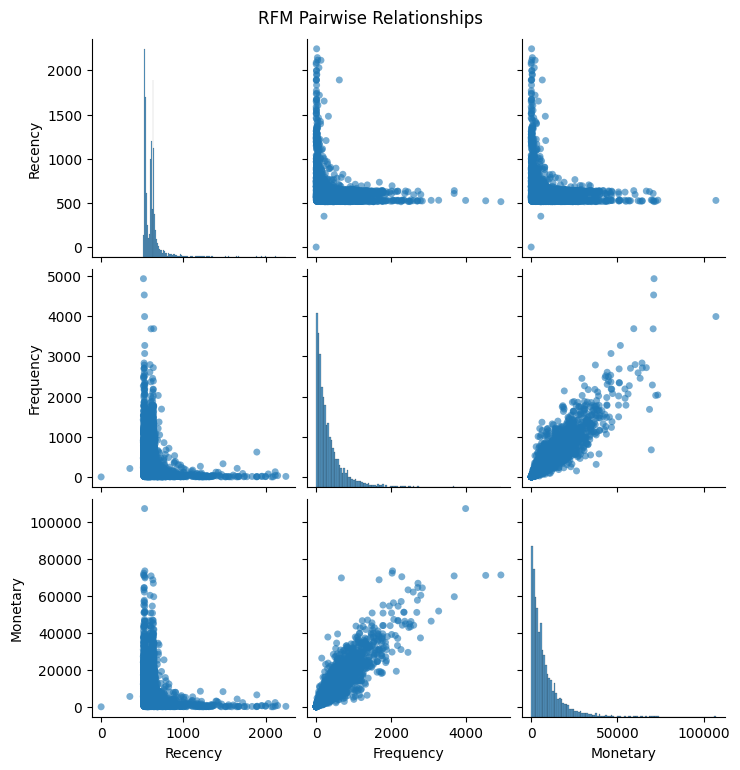

In [ ]:
# Convert the full RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation

# Select numeric RFM columns (+ cluster if present) and convert to Pandas
rfm_cols = ["Recency", "Frequency", "Monetary"]
extra_cols = ["RFM_Cluster"] if "RFM_Cluster" in rfm.columns else []
pdf_rfm = rfm.select(*(rfm_cols + extra_cols)).toPandas()

# Generate a pairplot to visualise the relationships between the numeric RFM columns

#  Pairplot
hue_arg = "RFM_Cluster" if "RFM_Cluster" in pdf_rfm.columns else None
sns.pairplot(
    pdf_rfm,
    vars=rfm_cols,
    hue=hue_arg,
    diag_kind="hist",
    plot_kws={"alpha": 0.6, "s": 25, "edgecolor": "none"}
)

plt.suptitle("RFM Pairwise Relationships", y=1.02)
plt.show()


### Behavioral Trends Analysis <font color = red>[8 marks]</font> <br>

Perform RFM analysis to study the behavior of customers to tailor marketing strategies

In [ ]:
#RFM: compute, normalize, export for sklearn ===

# Imports
from pyspark.sql.functions import (
    col, to_timestamp, coalesce, max as spark_max, datediff, lit,
    countDistinct, sum as spark_sum
)
from pyspark.sql import functions as F

# Working DataFrame (engineered df if present, else cleaned)
base_df = df if 'df' in globals() else df_final

# Robust timestamp from "Order Date" (tries MDY and DMY)
df_rfm_src = base_df.withColumn(
    "Order_Timestamp",
    coalesce(
        to_timestamp(col("Order Date")),
        to_timestamp(col("Order Date"), "MM/dd/yyyy"),
        to_timestamp(col("Order Date"), "dd/MM/yyyy")
    )
)

# Monetary column: Total_Value = Unit Price × Quantity (if missing)
if "Total_Value" not in df_rfm_src.columns:
    df_rfm_src = (df_rfm_src
                  .withColumn("Purchase Price Per Unit", col("Purchase Price Per Unit").cast("double"))
                  .withColumn("Quantity", col("Quantity").cast("int"))
                  .withColumn("Total_Value", col("Purchase Price Per Unit") * col("Quantity"))
                 )

#  Frequency identifier: use ASIN/ISBN if available, else Title
product_col = "ASIN/ISBN (Product Code)" if "ASIN/ISBN (Product Code)" in df_rfm_src.columns else "Title"

# Latest order timestamp (for Recency)
max_order_ts = df_rfm_src.agg(spark_max("Order_Timestamp").alias("MaxDate")).collect()[0]["MaxDate"]

# RFM per customer
rfm = (df_rfm_src.groupBy("Survey ResponseID")
       .agg(
           spark_max("Order_Timestamp").alias("Last_Purchase_Timestamp"),  # most recent purchase date
           countDistinct(col(product_col)).alias("Frequency"),              # distinct products bought
           spark_sum("Total_Value").alias("Monetary")                       # total spend
       )
       .withColumn("Recency", datediff(lit(max_order_ts), col("Last_Purchase_Timestamp")))
       .filter(col("Frequency") > 0)  # keep only purchasers
       .withColumnRenamed("Survey ResponseID", "CustomerID")
       .select("CustomerID", "Recency", "Frequency", "Monetary")
      )

# Normalize distributions (log1p)
rfm_log = (rfm.withColumn("Recency_log",  F.log1p(col("Recency")))
              .withColumn("Frequency_log", F.log1p(col("Frequency")))
              .withColumn("Monetary_log",  F.log1p(col("Monetary"))))

#  Convert to Pandas for sklearn
pdf_rfm = rfm_log.toPandas()

#  Standardize for clustering (sklearn)

feature_cols = ["Recency_log", "Frequency_log", "Monetary_log"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pdf_rfm[feature_cols])

print("RFM customers:", rfm.count())
rfm.show(5, truncate=False)
print("pdf_rfm shape:", pdf_rfm.shape)
print(rfm_scaled_df.head(3))


RFM customers: 5021
+-----------------+-------+---------+------------------+
|CustomerID       |Recency|Frequency|Monetary          |
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|525    |969      |28274.679999999924|
|R_1CqGMkfiCiATbn4|528    |94       |5775.459999999999 |
|R_1eWdieBjoYJXAYv|606    |820      |26188.559999999932|
|R_1esG9Jlh9NISLaO|529    |335      |6621.719999999997 |
|R_1gG5xibh48txT6f|523    |559      |12959.079999999965|
+-----------------+-------+---------+------------------+
only showing top 5 rows

pdf_rfm shape: (5021, 7)
   Recency_scaled  Frequency_scaled  Monetary_scaled
0       -0.747573          1.399935         1.477749
1       -0.718425         -0.006457         0.230197
2        5.826596         -2.513909        -2.023584


In [ ]:
# Apply K-Means clustering

if 'X_scaled' in globals():
    X = X_scaled
elif 'rfm_scaled_df' in globals():
    X = rfm_scaled_df[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]].values
else:
    raise NameError("Scaled features not found. Define X_scaled or rfm_scaled_df first.")

# Also pick the Pandas row-aligned table with CustomerID for attaching labels
if 'pdf_rfm' in globals():
    pdf_for_labels = pdf_rfm.copy()
elif 'rfm_scaled_df' in globals() and "CustomerID" in rfm_scaled_df.columns:
    pdf_for_labels = rfm_scaled_df[["CustomerID"]].copy()
else:
    raise NameError("CustomerID-bearing Pandas DataFrame not found (expected pdf_rfm or rfm_scaled_df with CustomerID).")

#  Fit K-Means with your chosen k (set from elbow method)
optimal_k = 4  # <-- change based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

#  Add predicted labels to Pandas DataFrame
pdf_for_labels["RFM_Cluster"] = labels

# Convert the Pandas DataFrame back to Spark
rfm_clusters_spark = spark.createDataFrame(pdf_for_labels[["CustomerID", "RFM_Cluster"]])

#  Join labels onto the Spark RFM table
rfm_with_cluster = rfm.join(rfm_clusters_spark, on="CustomerID", how="left")

#  Preview final result
rfm_with_cluster.select("CustomerID", "Recency", "Frequency", "Monetary", "RFM_Cluster").show(10, truncate=False)


+-----------------+-------+---------+------------------+-----------+
|CustomerID       |Recency|Frequency|Monetary          |RFM_Cluster|
+-----------------+-------+---------+------------------+-----------+
|R_10TV1zyi4yCEEkl|525    |969      |28274.679999999924|0          |
|R_1CqGMkfiCiATbn4|528    |94       |5775.459999999999 |1          |
|R_1eWdieBjoYJXAYv|606    |820      |26188.559999999932|0          |
|R_1esG9Jlh9NISLaO|529    |335      |6621.719999999997 |0          |
|R_1gG5xibh48txT6f|523    |559      |12959.079999999965|0          |
|R_1jO4s7oht3pyKEc|518    |529      |12619.349999999971|0          |
|R_1l6oxKA9uiM9GUo|632    |163      |5199.630000000001 |1          |
|R_1li5HiNnFHiD7yw|533    |125      |2882.2200000000007|1          |
|R_1mxX9jjBSLwxiDU|545    |222      |2653.5500000000006|1          |
|R_21vtzOUrbyaVnsL|797    |56       |1110.9799999999998|2          |
+-----------------+-------+---------+------------------+-----------+
only showing top 10 rows



Analyse the Cluster Distribution by Income <font color = red>[2 marks]</font> <br>


+-----------+-------------------+--------------+
|RFM_Cluster|Q-demos-income     |Customer_Count|
+-----------+-------------------+--------------+
|0          |$100,000 - $149,999|394           |
|0          |$50,000 - $74,999  |386           |
|0          |$75,000 - $99,999  |333           |
|0          |$25,000 - $49,999  |316           |
|0          |$150,000 or more   |276           |
|0          |Less than $25,000  |133           |
|0          |Prefer not to say  |17            |
|1          |$25,000 - $49,999  |551           |
|1          |$50,000 - $74,999  |437           |
|1          |Less than $25,000  |327           |
+-----------+-------------------+--------------+
only showing top 10 rows



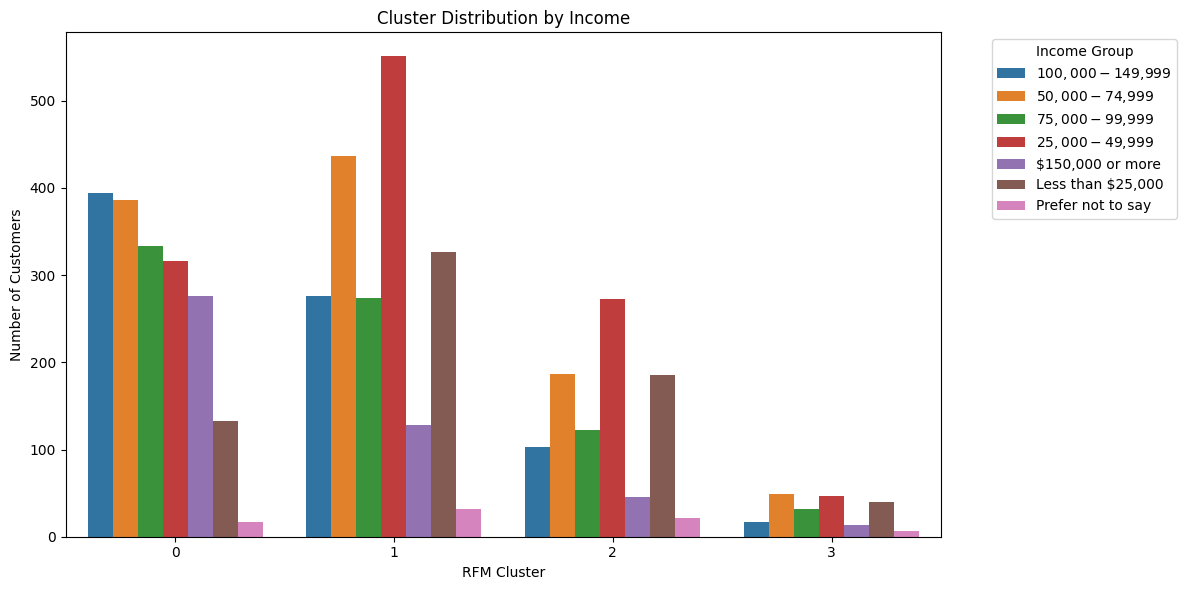

In [ ]:
#Trend 1: Cluster Distribution by Income

# Import the necessary function for counting records in PySpark
from pyspark.sql.functions import count as spark_count

rfm_income = (
    rfm_with_cluster.join(
        survey,
        rfm_with_cluster.CustomerID == survey["Survey ResponseID"],
        how="left"
    )
)

#  Aggregate: count customers per cluster × income group
cluster_income = (
    rfm_income.groupBy("RFM_Cluster", "Q-demos-income")
              .agg(spark_count("*").alias("Customer_Count"))
              .orderBy("RFM_Cluster", "Customer_Count", ascending=[True, False])
)

cluster_income.show(10, truncate=False)

#  Convert to Pandas for plotting
pdf_cluster_income = cluster_income.toPandas()

#  Plot: Cluster distribution by Income
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pdf_cluster_income,
    x="RFM_Cluster",
    y="Customer_Count",
    hue="Q-demos-income"
)
plt.title("Cluster Distribution by Income")
plt.xlabel("RFM Cluster")
plt.ylabel("Number of Customers")
plt.legend(title="Income Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Analyse the Average Spending by Cluster <font color = red>[2 marks]</font> <br>


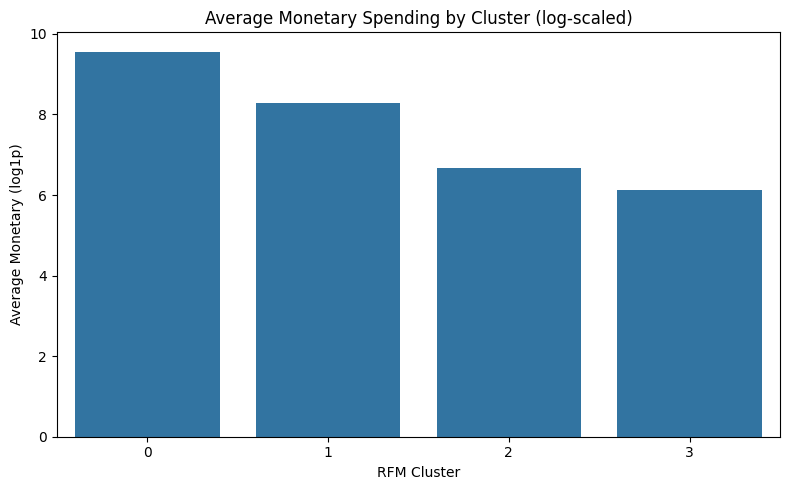

In [ ]:
# --- Build a clean frame: CustomerID + RFM + Cluster (no dups) ---

from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg

#  Start from the authoritative RFM (one set of R, F, M)
rfm_base = rfm.select("CustomerID", "Recency", "Frequency", "Monetary")

# Keep only (CustomerID, RFM_Cluster) from the clustered table and dedupe
clusters_only = (
    rfm_with_cluster
    .select("CustomerID", "RFM_Cluster")
    .dropDuplicates(["CustomerID"])
)

#  Join: one Frequency only
rfm_wc_clean = (
    rfm_base.alias("r")
    .join(clusters_only.alias("c"), on="CustomerID", how="inner")
)

# Add logs directly here (no extra joins → no ambiguity)
rfm_wc_clean = (
    rfm_wc_clean
    .withColumn("Recency_log",  F.log1p(col("Recency")))
    .withColumn("Monetary_log", F.log1p(col("Monetary")))
)

cluster_summary = (
    rfm_wc_clean.groupBy("RFM_Cluster")
    .agg(
        avg("Recency_log").alias("Avg_Recency_log"),
        avg("Frequency").alias("Avg_Frequency"),
        avg("Monetary_log").alias("Avg_Monetary_log")
    )
    .orderBy("RFM_Cluster")
)

# Convert to Pandas and plot
pdf_cluster_summary = cluster_summary.toPandas()

# Bar: Average Monetary (log) per cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=pdf_cluster_summary, x="RFM_Cluster", y="Avg_Monetary_log")
plt.title("Average Monetary Spending by Cluster (log-scaled)")
plt.xlabel("RFM Cluster")
plt.ylabel("Average Monetary (log1p)")
plt.tight_layout()
plt.show()



Analyse the Purchase Frequency vs. Recency <font color = red>[2 marks]</font> <br>


          CustomerID  Recency  Frequency
0  R_10TV1zyi4yCEEkl      525        969
1  R_1CqGMkfiCiATbn4      528         94
2  R_1eWdieBjoYJXAYv      606        820
3  R_1esG9Jlh9NISLaO      529        335
4  R_1gG5xibh48txT6f      523        559


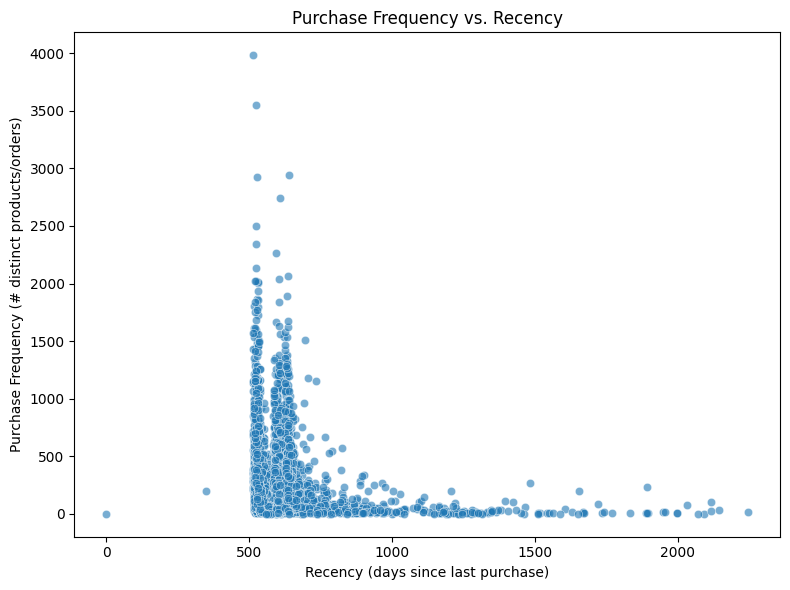

In [ ]:
#Trend 3: Purchase Frequency vs. Recency

# Convert the RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation
pdf_rfm = rfm.select("CustomerID", "Recency", "Frequency").toPandas()

print(pdf_rfm.head())

# Generate a scatter plot to analyse the relationship between Purchase Frequency and Recency
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pdf_rfm,
    x="Recency",
    y="Frequency",
    alpha=0.6
)

plt.title("Purchase Frequency vs. Recency")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Purchase Frequency (# distinct products/orders)")
plt.tight_layout()
plt.show()

Analyse the top categories by clusters <font color = red>[2 marks]</font> <br>


In [ ]:
#Trend 4: Top Categories by Cluster

# Import the necessary function to calculate the sum in PySpark
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

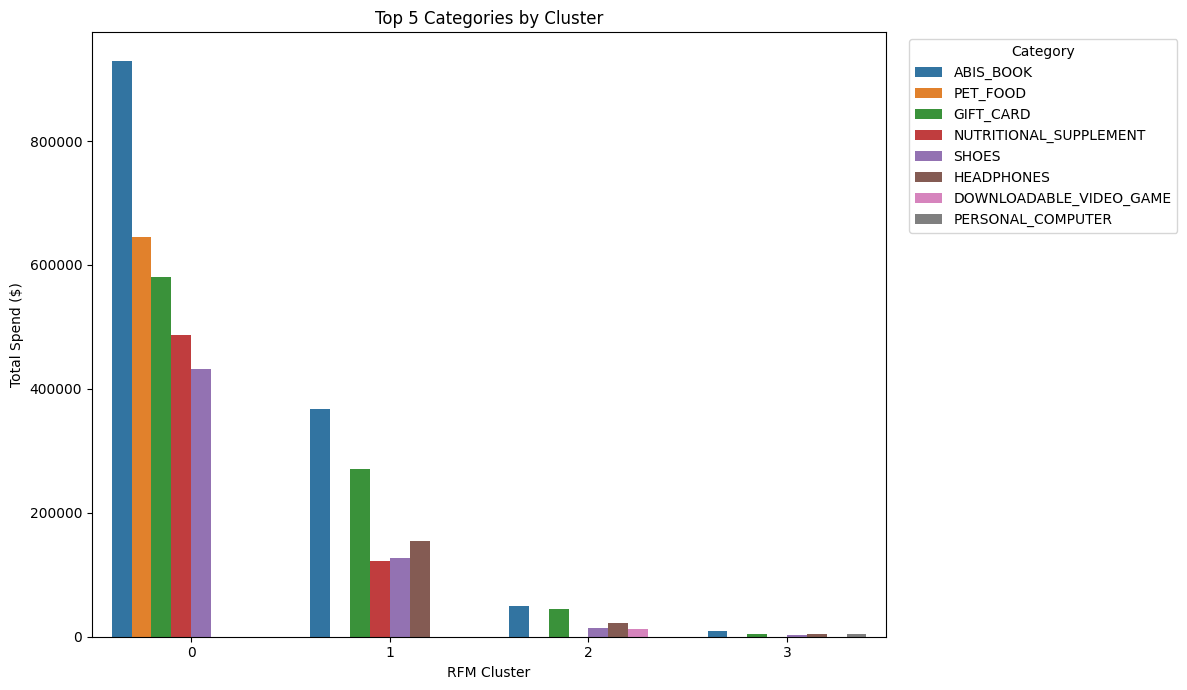

In [ ]:
# Join the merged dataset with the RFM dataset to associate each customer with their respective cluster
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity"))

# Ensure Total_Value exists
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity"))

# Join with clusters
purchases_clustered = purchases_df.join(
    rfm_with_cluster.select("CustomerID", "RFM_Cluster").dropDuplicates(),
    purchases_df["Survey ResponseID"] == F.col("CustomerID"),
    "inner"
)

# Top 5 categories per cluster
w = Window.partitionBy("RFM_Cluster").orderBy(F.col("Total_Spend").desc())
top_cats = (purchases_clustered.groupBy("RFM_Cluster", "Category")
            .agg(F.sum("Total_Value").alias("Total_Spend"))
            .withColumn("rn", F.row_number().over(w))
            .filter("rn <= 5")
            .orderBy("RFM_Cluster", F.col("Total_Spend").desc())
            .select("RFM_Cluster", "Category", "Total_Spend"))

# Convert to Pandas
pdf_top_cats = top_cats.toPandas()

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=pdf_top_cats, x="RFM_Cluster", y="Total_Spend", hue="Category")
plt.title("Top 5 Categories by Cluster")
plt.xlabel("RFM Cluster")
plt.ylabel("Total Spend ($)")
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 4.2 Insights <font color = red>[35 marks]</font> <br>


### 4.2.1 When to schedule effective promotions. <font color = red>[3 marks]</font> <br>

Compare sales across weekdays to schedule effective promotions

/tmp/ipython-input-1364512402.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_weekday_sales, x="Weekday", y="Total_Sales", palette="viridis")


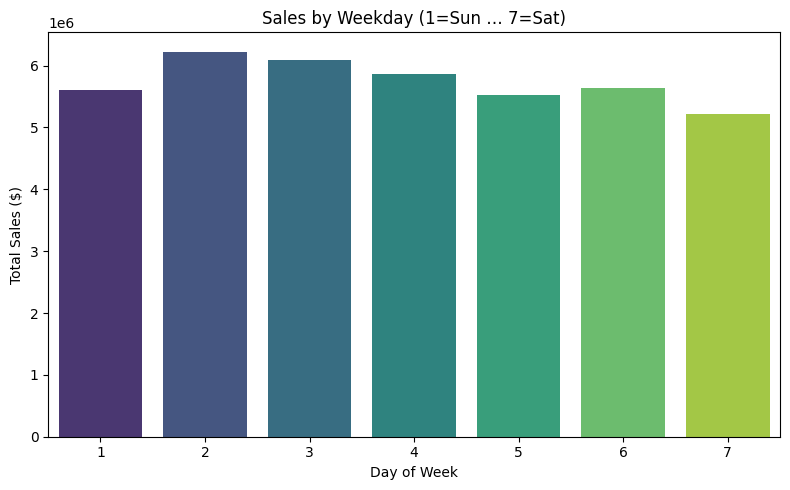

In [ ]:
#Compare sales across weekdays to schedule effective promotions

from pyspark.sql.functions import dayofweek, sum as spark_sum, col
import matplotlib.pyplot as plt
import seaborn as sns

#  Make sure Total_Value exists
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", col("Quantity").cast("int")) \
    .withColumn("Total_Value", col("Purchase Price Per Unit") * col("Quantity"))

#  Extract weekday (1=Sunday, 7=Saturday)
purchases_weekday = purchases_df.withColumn("Weekday", dayofweek(col("Order_Date")))

#  Group by weekday → total sales
weekday_sales = purchases_weekday.groupBy("Weekday").agg(spark_sum("Total_Value").alias("Total_Sales"))

#  Convert to Pandas for plotting
pdf_weekday_sales = weekday_sales.toPandas().sort_values("Weekday")

#  Plot sales by weekday
plt.figure(figsize=(8,5))
sns.barplot(data=pdf_weekday_sales, x="Weekday", y="Total_Sales", palette="viridis")

plt.title("Sales by Weekday (1=Sun … 7=Sat)")
plt.xlabel("Day of Week")
plt.ylabel("Total Sales ($)")
plt.tight_layout()
plt.show()

### 4.2.2 Top-selling Products <font color = red>[2 marks]</font> <br>

Identify top-selling products by considering revenue and engagement metrics

/tmp/ipython-input-3842957866.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3842957866.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


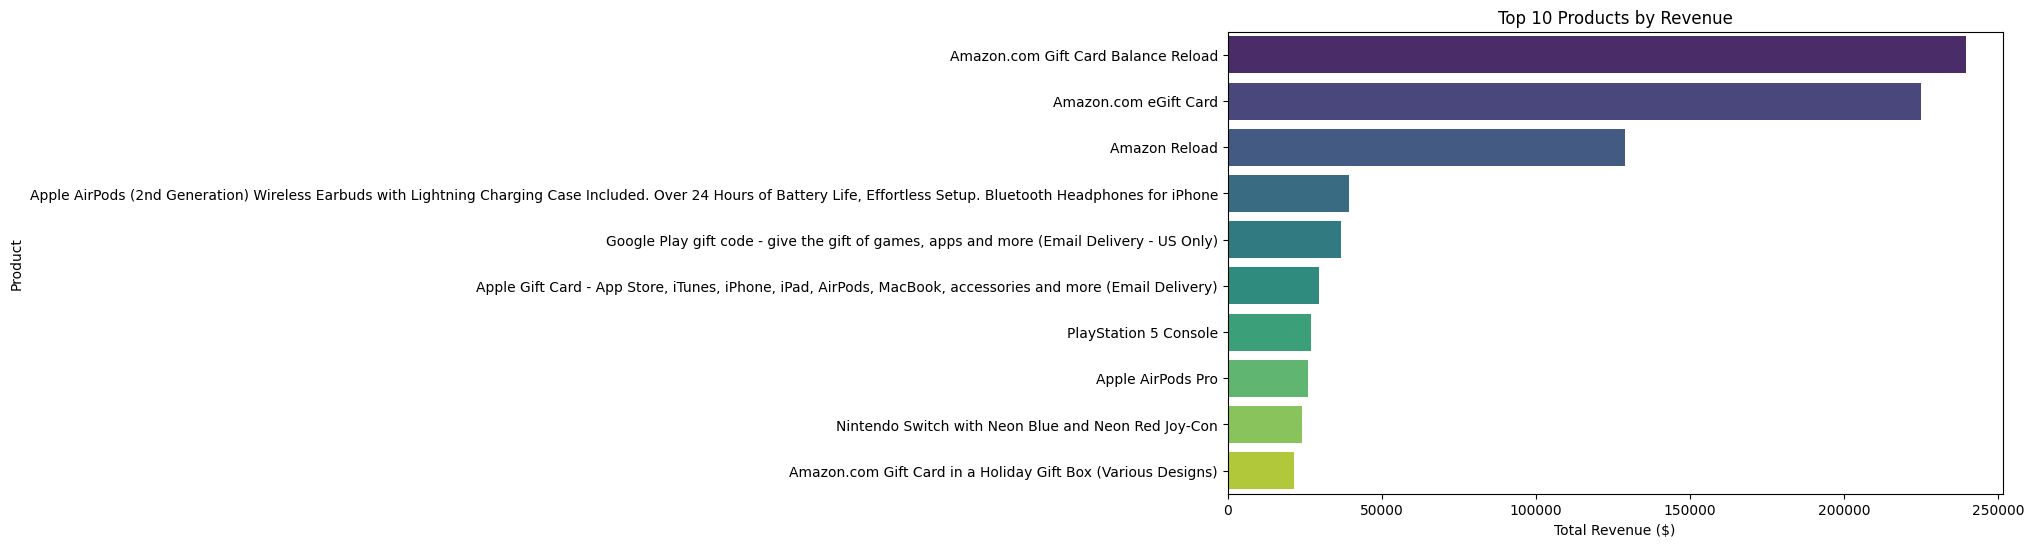

In [ ]:

# Ensure Total_Value exists
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity"))

# Group by product and calculate revenue + engagement (purchase counts)
product_sales = (purchases_df
                 .groupBy("Title")
                 .agg(
                     F.sum("Total_Value").alias("Total_Revenue"),
                     F.count("*").alias("Engagement_Count")
                 ))

#  Select top 10 products by revenue
top_products = product_sales.orderBy(F.col("Total_Revenue").desc()).limit(10)

# Convert to Pandas
pdf_top_products = top_products.toPandas()

# Plot top products by revenue
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pdf_top_products.sort_values("Total_Revenue", ascending=False),
    x="Total_Revenue", y="Title", palette="viridis"
)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

### 4.2.3 State-wise revenue Distribution <font color = red>[5 marks]</font> <br>

Assess state-wise revenue to focus on high-growth areas

/tmp/ipython-input-4116341766.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_revenue, x="Revenue", y="Shipping Address State", palette="mako")


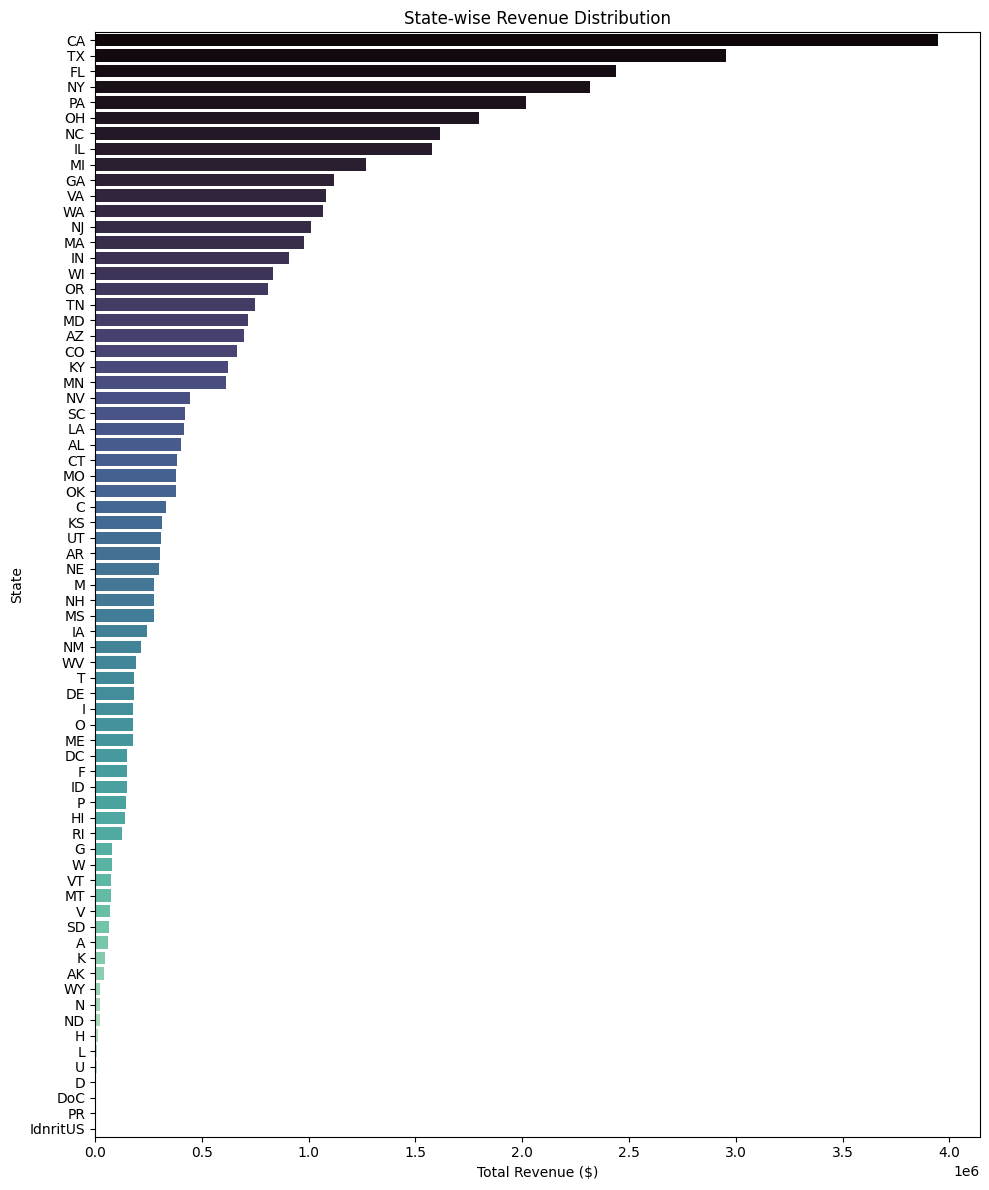

In [ ]:
# Compute revenue per state
state_revenue = (df_final
    .withColumn("Total_Value", F.col("Purchase Price Per Unit").cast("double") * F.col("Quantity").cast("int"))
    .groupBy("Shipping Address State")
    .agg(F.sum("Total_Value").alias("Revenue"))
    .orderBy(F.col("Revenue").desc())
    .toPandas())

#  Plot state-wise revenue
plt.figure(figsize=(10,12))
sns.barplot(data=state_revenue, x="Revenue", y="Shipping Address State", palette="mako")
plt.title("State-wise Revenue Distribution")
plt.xlabel("Total Revenue ($)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

### 4.2.4 Repeat Purchase Behavior <font color = red>[5 marks]</font> <br>

Examine repeat purchase behavior to enhance retention initiatives.

In [ ]:
#Examine repeat purchase behavior to enhance retention initiatives

from pyspark.sql.functions import count, col

#  Count purchases per customer
cust_purchase_counts = (df_final
    .groupBy("Survey ResponseID")
    .agg(F.count("*").alias("Total_Purchases"))
)

#  Filter repeat customers (more than 1 purchase)
repeat_customers = cust_purchase_counts.filter(F.col("Total_Purchases") > 1)

#  Show a sample of repeat buyers
repeat_customers.show(10, truncate=False)


+-----------------+---------------+
|Survey ResponseID|Total_Purchases|
+-----------------+---------------+
|R_10TV1zyi4yCEEkl|1058           |
|R_1CqGMkfiCiATbn4|182            |
|R_1LBvKYfg8hgoloJ|7              |
|R_1N52McSjcCnVqIm|11             |
|R_1NfYBCMTmzHgXGh|3              |
|R_1QgWXnlpERvWjrY|78             |
|R_1eWdieBjoYJXAYv|920            |
|R_1esG9Jlh9NISLaO|357            |
|R_1gG5xibh48txT6f|590            |
|R_1jO4s7oht3pyKEc|596            |
+-----------------+---------------+
only showing top 10 rows



### 4.2.5 Flagging Potential Fraud <font color = red>[5 marks]</font> <br>

Identify irregular transaction patterns to flag potential fraud.

In [ ]:
#Identify irregular transaction patterns to flag potential fraud

from pyspark.sql.functions import col, avg, stddev

#  Ensure Total_Value exists
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity"))

#  Calculate mean and std dev of spending
stats = purchases_df.agg(
    F.avg("Total_Value").alias("mean_val"),
    F.stddev("Total_Value").alias("std_val")
).collect()[0]

mean_val, std_val = stats["mean_val"], stats["std_val"]

#  Threshold = mean + 3 * stddev
threshold = mean_val + 3 * std_val

#  Flag suspicious transactions
suspicious_txns = purchases_df.filter(F.col("Total_Value") > threshold)

#  Show suspicious transactions
print("Threshold for suspicious spending:", threshold)
suspicious_txns.select("Survey ResponseID", "Order Date", "Title", "Total_Value").show(10, truncate=False)

Threshold for suspicious spending: 163.33093122891896
+-----------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|Survey ResponseID|Order Date|Title                                                                                                                                                                                                 |Total_Value|
+-----------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|R_01vNIayewjIIKMF|2021-06-13|Google Pixel 4a - Unlocked Android Smartphone - 128 GB of Storage - Up to 24 Hour Battery - Just Black                                                                                        

### 4.2.6 Demand Variations across product categories <font color = red>[5 marks]</font> <br>

Perform inventory management by monitoring demand variations across product categories.

<Figure size 1200x700 with 0 Axes>

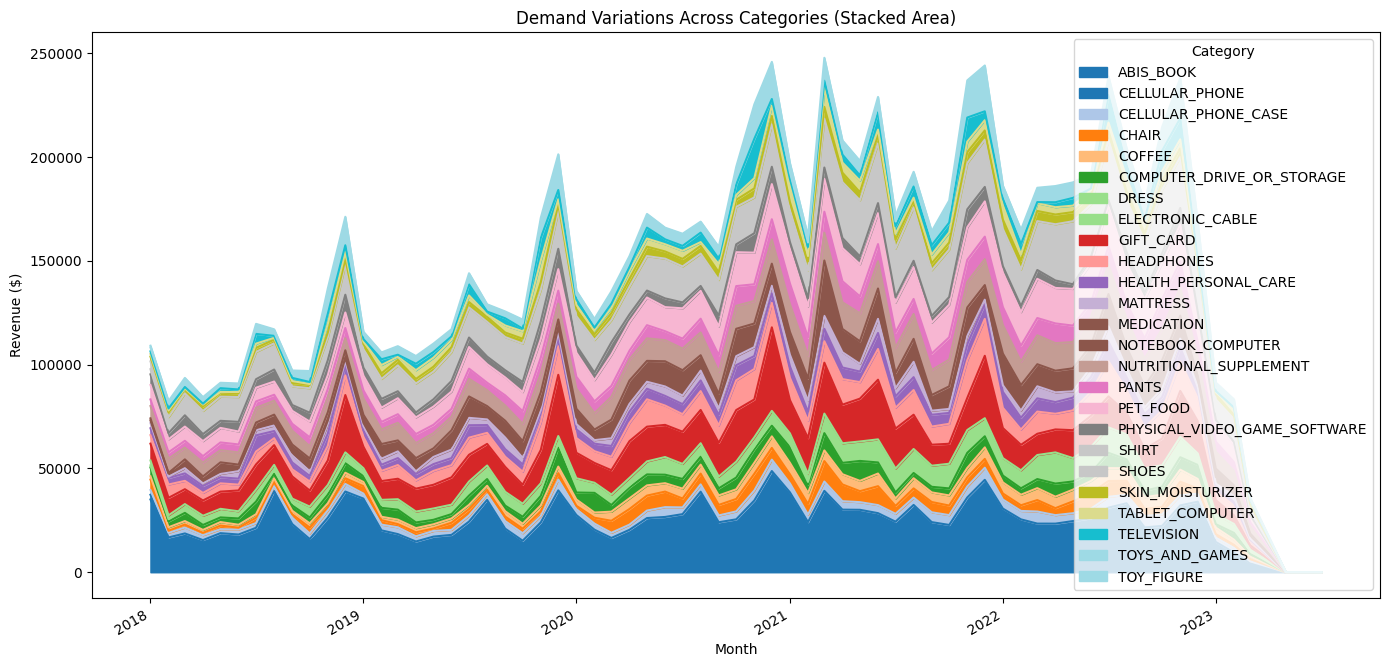

In [ ]:
#Monitor demand variations across product categories (Top 25) for inventory management

from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import seaborn as sns

#  Ensure revenue + timestamp
base = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity")) \
    .withColumn("Order_Timestamp",
                F.coalesce(
                    F.to_timestamp("Order Date"),
                    F.to_timestamp("Order Date", "MM/dd/yyyy"),
                    F.to_timestamp("Order Date", "dd/MM/yyyy")
                )) \
    .withColumn("YearMonth", F.date_format("Order_Timestamp", "yyyy-MM"))

#  Category × Month revenue trend
category_trends = (base.groupBy("Category", "YearMonth")
                        .agg(F.sum("Total_Value").alias("Revenue")))

# Top 25 categories by total revenue
cat_totals = (category_trends.groupBy("Category")
                             .agg(F.sum("Revenue").alias("Total_Revenue"))
                             .orderBy(F.col("Total_Revenue").desc()))
top25 = [r["Category"] for r in cat_totals.limit(25).collect()]

#  Keep only Top 25
top_trends = (category_trends.filter(F.col("Category").isin(top25))
                             .orderBy("YearMonth"))

#  To Pandas for viz
pdf = top_trends.toPandas()
pdf["YearMonth_dt"] = pd.to_datetime(pdf["YearMonth"], format="%Y-%m")

# Plot (monthly revenue, hue=category)
plt.figure(figsize=(12,7))
pdf_pivot = pdf.pivot(index="YearMonth_dt", columns="Category", values="Revenue").fillna(0)
pdf_pivot.plot.area(figsize=(14,7), colormap="tab20")
plt.title("Demand Variations Across Categories (Stacked Area)")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

### 4.2.7 Assess how bulk purchases affect revenue and supply chain operations <font color = red>[5 marks]</font> <br>

Analyse the impact of how bulk purchasing behavior affects revenue and the overall supply chain operations.

/tmp/ipython-input-3272239706.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bulk, x="Bulk_Revenue", y="Category", palette="coolwarm")


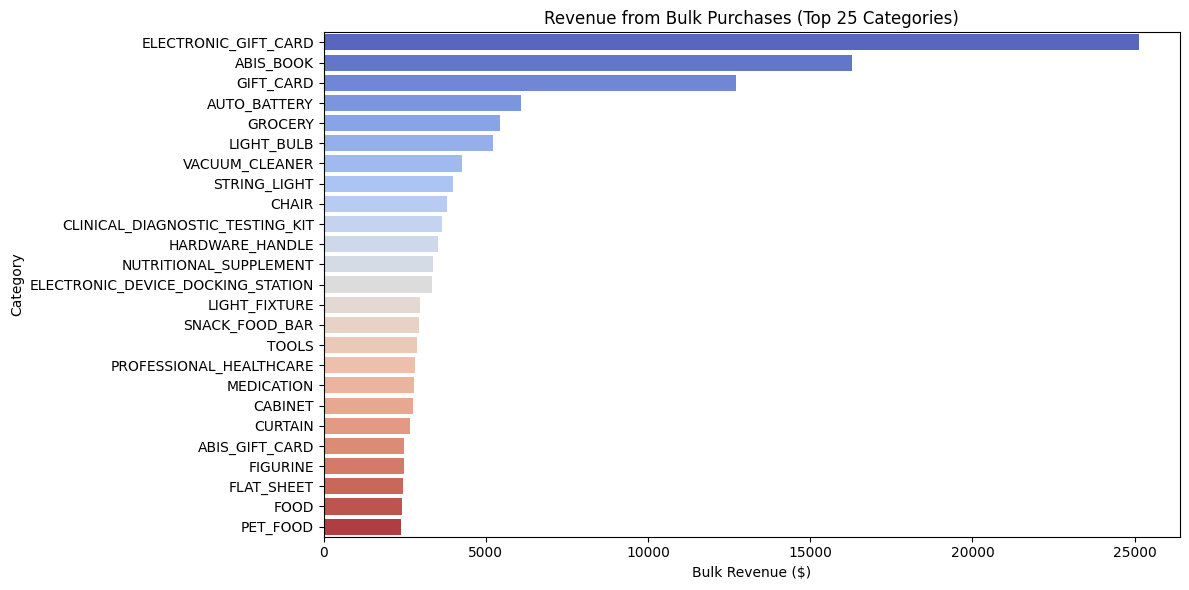

In [ ]:
#Assess how bulk purchases affect revenue and supply chain operations

# Bulk Purchases Impact on Revenue (Top 25 Categories)

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

#  Ensure Total_Value exists
purchases_df = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity"))

#  Filter bulk purchases (Quantity > 5) → group revenue per category
bulk_revenue = (purchases_df
    .filter(F.col("Quantity") > 5)
    .groupBy("Category")
    .agg(F.sum("Total_Value").alias("Bulk_Revenue"))
    .orderBy(F.col("Bulk_Revenue").desc())
)

#  Top 25 categories
top_bulk = bulk_revenue.limit(25).toPandas()

#  Plot bulk purchase revenue
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bulk, x="Bulk_Revenue", y="Category", palette="coolwarm")
plt.title("Revenue from Bulk Purchases (Top 25 Categories)")
plt.xlabel("Bulk Revenue ($)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

### 4.2.8 Compare lifecycle strategies <font color = red>[5 marks]</font> <br>

Compare new and established products to inform and compare lifecycle strategies to make informed decisions.

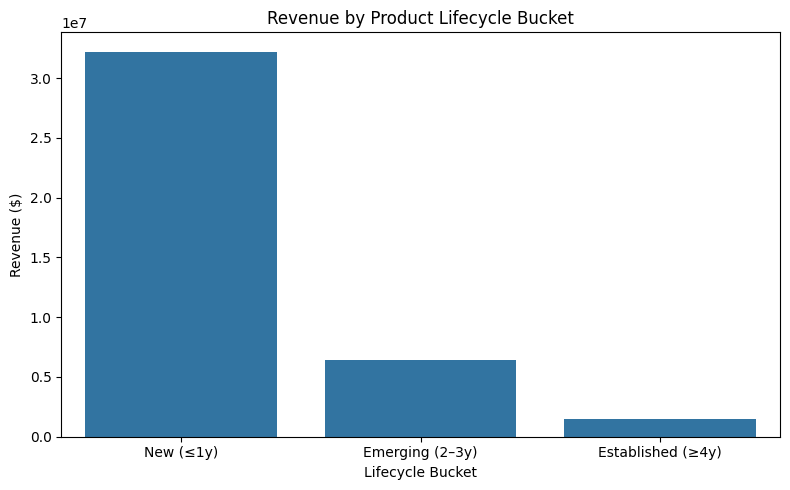

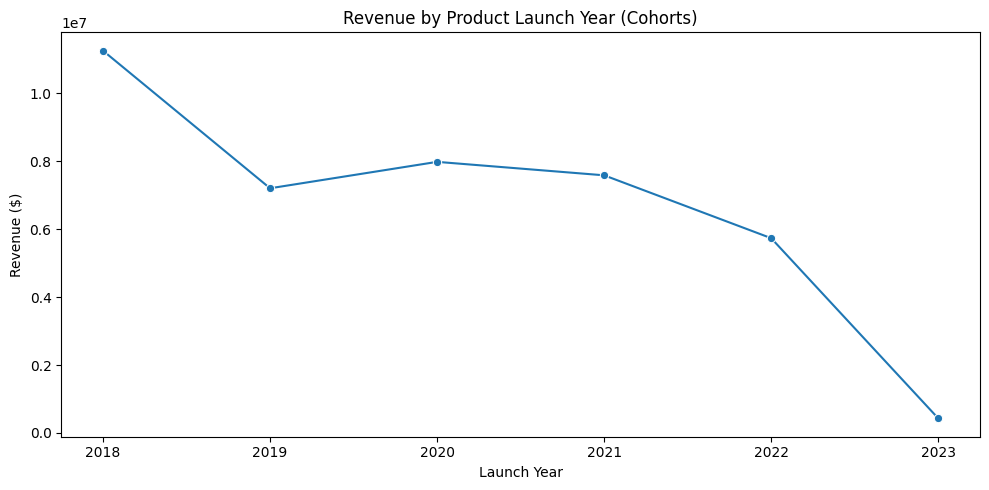

In [ ]:
#Compare new and established products to inform lifecycle strategies

from pyspark.sql.functions import min, sum

#  Base with revenue + timestamp + order year
base = (df if 'df' in globals() else df_final) \
    .withColumn("Purchase Price Per Unit", F.col("Purchase Price Per Unit").cast("double")) \
    .withColumn("Quantity", F.col("Quantity").cast("int")) \
    .withColumn("Total_Value", F.col("Purchase Price Per Unit") * F.col("Quantity")) \
    .withColumn("Order_Ts", F.coalesce(
        F.to_timestamp("Order Date"),
        F.to_timestamp("Order Date", "MM/dd/yyyy"),
        F.to_timestamp("Order Date", "dd/MM/yyyy")
    )) \
    .withColumn("Order_Year", F.year("Order_Ts"))

# Launch year per product (first observed sale year)
product_launch = base.groupBy("Title").agg(F.min("Order_Year").alias("Launch_Year"))

#  Join launch year back, compute product age at time of each sale
with_age = (base.join(product_launch, on="Title", how="left")
                .withColumn("Product_Age", F.col("Order_Year") - F.col("Launch_Year"))
                .withColumn(
                    "Lifecycle_Bucket",
                    F.when(F.col("Product_Age") <= 1, "New (≤1y)")
                     .when(F.col("Product_Age") <= 3, "Emerging (2–3y)")
                     .otherwise("Established (≥4y)")
                ))

#  Revenue by lifecycle bucket (core comparison)
bucket_rev = (with_age.groupBy("Lifecycle_Bucket")
                      .agg(F.sum("Total_Value").alias("Revenue"))
                      .orderBy(F.col("Revenue").desc()))
pdf_bucket = bucket_rev.toPandas()

#  Plots
plt.figure(figsize=(8,5))
sns.barplot(data=pdf_bucket, x="Lifecycle_Bucket", y="Revenue")
plt.title("Revenue by Product Lifecycle Bucket")
plt.xlabel("Lifecycle Bucket")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=pdf_launch, x="Launch_Year", y="Revenue", marker="o")
plt.title("Revenue by Product Launch Year (Cohorts)")
plt.xlabel("Launch Year")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

#5 Conclusion <font color = red>[10 marks]</font> <br>

Write your conclusion.

Customer behavior analysis reveals clear patterns in purchases, demographics, and product trends. Seasonal and weekday insights highlight promotion opportunities, while RFM segmentation pinpoints loyal customers. Revenue by state and category supports growth planning. Repeat purchase, fraud detection, and bulk buying analysis guide loyalty, security, and supply chain decisions effectively.


Promotions: Midweek and seasonal campaigns can improve sales during low-demand periods.

Segmentation: High-value clusters should be prioritized for retention and loyalty initiatives.

Operations: Bulk purchasing and product lifecycle insights guide supply chain optimization.